In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import re
from skimage import io
import tifffile
from scipy.ndimage import median_filter
from skimage.util import img_as_ubyte,  img_as_float
import skimage
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import scipy
import seaborn as sns
from scipy import stats

import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test

from statannotations.Annotator import Annotator
from itertools import combinations
import statsmodels
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

# Set Paths
codedir = os.getcwd()
os.chdir('..')
import util
os.chdir(codedir)

%matplotlib inline

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#images: dowload from synapse.org syn51068458
# (free account required)
rootdir = '/home/groups/BCC_Chin_Lab/ChinData/Cyclic_Workflow/cmIF_2021-05-03_PDAC'
regdir = f'{rootdir}/RegisteredImages'
segdir = f'{codedir}/Segmentation'
segdiro = f'{rootdir}/Segmentation'

# clone mplex_image at https://gitlab.com/engje/mplex_image
os.chdir('/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data')
from mplex_image import preprocess, mpimage #, cmif
os.chdir(codedir)

# Table of contents <a name="contents"></a>
0. [functions](#func)
1. [skimage blobs](#sk)
2. [Foci analysis](#focifoci)
3. [mIHC analysis](#mihc)
4. [CPH modeling](#clin)

5. [gene expression analysis](#geneexp)
6. [TCR analysis](#tcell)
7. [High v. low pORG](#split)

In [3]:
import scipy
from skimage.filters import unsharp_mask
import skimage
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import color, morphology
from skimage.transform import rescale

## functions <a name="func"></a> 

[contents](#contents)

In [4]:
def get_blobs2(image_gray,min_sigma,max_sigma,threshold,exclude_border):

    blobs_dog = blob_dog(image_gray,  min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold,exclude_border=exclude_border)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_list = [image_gray,  blobs_dog] #blobs_doh ,
    colors = ['red','red', ]
    titles = ['Original','Difference of Gaussian',#
              ]
    sequence = zip(blobs_list, colors, titles)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        if idx == 1:
            ax[idx].set_title(f'{title}\nmin={min_sigma} max={max_sigma} thresh={threshold}')
        else:
            ax[idx].set_title(f'{title}')
        ax[idx].imshow(image)
        if not title == 'Original':
            for blob in blobs:
                y, x, r = blob
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax[idx].add_patch(c)
        #ax[idx].set_axis_off()

    plt.tight_layout()
    plt.close(fig)
    return(blobs_dog,fig)

def km_plot(df,s_col,s_time,s_censor):
    results = multivariate_logrank_test(event_durations=df.loc[:,s_time],
                                    groups=df.loc[:,s_col], event_observed=df.loc[:,s_censor])        
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(4,4),dpi=300)
    ls_order = sorted(df.loc[:,s_col].dropna().unique())
    for s_group in ls_order:
        print(s_group)
        df_abun = df[df.loc[:,s_col]==s_group]
        durations = df_abun.loc[:,s_time]
        event_observed = df_abun.loc[:,s_censor]
        kmf.fit(durations,event_observed,label=s_group)
        kmf.plot(ax=ax,ci_show=True,show_censors=True)
    ax.set_title(f'{s_col}\np={results.summary.p[0]:.2} n={[df.loc[:,s_col].value_counts()[item] for item in ls_order]}')
    ax.set_ylim(-0.05,1.05)
    return(fig,ls_order)

def cph_plot(df,s_multi,s_time,s_censor,figsize=(3,3)):
    cph = CoxPHFitter()  #penalizer=0.1
    if df.columns.isin(['Stage']).any():
        df.Stage = df.Stage.replace({'I':1,'II':2,'III':3,'IV':4})
    cph.fit(df.dropna(), s_time, event_col=s_censor) 
    fig, ax = plt.subplots(figsize=figsize,dpi=300)
    cph.plot(ax=ax)
    pvalue = cph.summary.p[s_multi]
    ax.set_title(f'{s_multi}\np={pvalue:.2} n={(len(df.dropna()))}')
    plt.tight_layout()
    return(fig,cph)
        
def plot_pearson(df_pri,s_porg,s_foci,s_stats,ls_plots=['Primaries','Mets','Both']):
    pvalues = []
    fig,ax=plt.subplots(1,len(ls_plots),figsize=(len(ls_plots)*3.3,2.7), sharex='col',sharey='row',squeeze=False,dpi=200)
    ax = ax.ravel()
    for idx,s_met_pri in enumerate(ls_plots):
        #print(s_met_pri)
        if s_met_pri == 'Mets':
            b_met = df_pri.Patient_Specimen_ID.str.contains('-M',na=False)
        elif s_met_pri == 'Primaries':
            b_met = ~(df_pri.Patient_Specimen_ID.str.contains('-M',na=True))
        else:
            b_met = df_pri.Patient_Specimen_ID.str.contains('ST-',na=False)
        sns.regplot(data=df_pri.loc[b_met,[s_porg,s_foci]],x=s_foci,y=s_porg,label=s_met_pri,ax=ax[idx])
        y = df_pri.loc[b_met,[s_foci,s_porg]].dropna().loc[:,s_foci]
        x = df_pri.loc[y.index,s_porg]
        if s_stats == 'non-parametric':
            statistic, pvalue = stats.spearmanr(x, y)
        else:
            statistic, pvalue = stats.pearsonr(x, y)
        pvalues.append(pvalue)
        if idx > 0:
            ax[idx].set_ylabel('')
        else:
            ax[idx].set_ylabel(s_porg.replace('trim_padj_0.2_',''))
        ax[idx].set_title(f'{s_met_pri} p={pvalue:.3}')
    plt.tight_layout()
    return(fig, pvalues)

# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from bioinfokit.analys import stat
def qq_plot_hist(df_pri,s_cat,s_foci):
    fig, ax = plt.subplots(2,1)
    res = stat()
    df_melt = df_pri.loc[~df_pri.loc[:,s_cat].isna(),[s_cat,s_foci]]
    df_melt.columns = ['treatments', 'value']
    res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
    # res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
    sm.qqplot(res.anova_std_residuals, line='45',ax=ax[0])
    ax[0].set_title(f'{s_foci} ({s_cat})')
    ax[0].set_xlabel("Theoretical Quantiles")
    ax[0].set_ylabel("Standardized Residuals")

    # histogram
    ax[1].hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
    ax[1].set_title(f'')
    ax[1].set_xlabel("Residuals")
    ax[1].set_ylabel('Frequency')
    plt.tight_layout()

def plot_violins(df_both,d_pval,d_order,s_stats,s_foci,order,ls_ticks,b_correct=False):
    figsize=(3,3)
    fig,ax=plt.subplots(dpi=300,figsize=figsize)
    if s_stats == 'non-parametric':
        sns.violinplot(data=df_both,y=s_foci,x='x',hue='hue',ax=ax,alpha=0.2,linewidth=1,cut=0,inner='quartile',hue_order=['bad','good'])#
    elif s_stats == 'mean':
        sns.violinplot(data=df_both,y=s_foci,x='x',hue='hue',ax=ax,alpha=0.2,linewidth=1,cut=0,inner=None,
                       hue_order=['bad','good'])
        sns.boxplot(data=df_both,y=s_foci,x='x',hue='hue',ax=ax,showmeans=True,medianprops={'visible': False},
                       whiskerprops={'visible': False},meanline=True,showcaps=False,
                       meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)#
    sns.stripplot(data=df_both,y=s_foci,x='x',hue='hue',s=3,dodge=True,ax=ax,palette='dark',jitter=0.2,alpha=0.8,hue_order=['bad','good']) #
    #annotate
    if len(order) == 6:
        pairs = [(order[0],order[1]),(order[2],order[3]),(order[4],order[5])]
        pvalues = [d_pval[list(d_order.keys())[0]],d_pval[list(d_order.keys())[1]],d_pval[list(d_order.keys())[2]]]
    elif len(order) == 4:
        pairs = [(order[0],order[1]),(order[2],order[3])]
        pvalues = [d_pval[list(d_order.keys())[0]],d_pval[list(d_order.keys())[1]]]
    else:
        pairs = [(order[0],order[1]),(order[2],order[3]),(order[4],order[5]),(order[6],order[7])]
        pvalues = [d_pval[list(d_order.keys())[0]],d_pval[list(d_order.keys())[1]],d_pval[list(d_order.keys())[2]],d_pval[list(d_order.keys())[3]]]
    reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
    formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(pvalues)]
    if b_correct:
        formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
    annotator = Annotator(ax, pairs=pairs, data=df_both,y=s_foci,x='x',hue='hue',verbose=False)
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
    ax.legend().remove()
    if len(order) == 6:
        ax.set_xticks([-0.2,0.2, 0.8,1.2,1.8,2.2])
    elif len(order) == 4:
        ax.set_xticks([-0.2,0.2, 0.8,1.2])
    else:
        ax.set_xticks([-0.2,0.2, 0.8,1.2,1.8,2.2,2.8,3.2])
    ax.set_xticklabels(ls_ticks,rotation=45)
    df_label = df_both.dropna().groupby('x').count().hue.loc[d_order.keys()]
    ls_labs = [f'{item.replace("Subtype","")} n={df_label[item]}' for item in df_label.index]
    ax.set_xlabel(" | ".join(ls_labs),fontsize=8)
    ax.set_title(f"{s_foci}", fontsize='x-large') #
    plt.tight_layout()
    return(fig,pvalues,corrected)
    

##  Section 1: skimage blob detection

Foci are detected here from images plus segmentation masks

**You can skip and use pre-computed foci counts**

 <a name="sk"></a> 

[contents](#contents)

In [ ]:
#intensity data: dowload from synapse.org syn51068458
df_mi = pd.read_csv(f'{codedir}/data/20220720_U54-TMA_FilteredMeanIntensity_Link.csv',index_col=0)

In [ ]:
#skimage blob detection
#requires images: dowload from synapse.org syn51068458
threshold=0.002
d_thresh = {'pRPA':1100, 'gH2AX':1100, 'RAD51':1300}
os.chdir(regdir)
ls_slide = sorted(set(df_mi.slide_scene)) 
ls_marker = ['pRPA','gH2AX','RAD51',] 
df_result_all = pd.DataFrame()
for s_slide in ls_slide:
    print(s_slide)
    os.chdir(f'{segdiro}/U54-TMA-9_CellposeSegmentation') #change this to path for your downloaded segmentation masks
    s_seg = pd.Series(sorted(os.listdir()),dtype='object')[pd.Series(index=sorted(os.listdir()),dtype='object').index.str.contains(f'{s_slide}_nuc30_NucleiSegmentationBasins')].iloc[0]
    label_image = io.imread(s_seg)
    os.chdir(f'{regdir}/{s_slide}') # change this to path to your downloaded registered tifs
    df_img=mpimage.parse_org()
    for idxs, s_marker in enumerate(ls_marker):
        intensity_image = io.imread(df_img[df_img.marker==s_marker].index[0])
        props = skimage.measure.regionprops_table(label_image, intensity_image=intensity_image, properties=('label','bbox','mean_intensity')) # 'image','intensity_image',
        df_props = pd.DataFrame(props,dtype='float').set_index('label')
        df_props.columns = [item.replace('-','') for item in df_props.columns]
        ls_index = df_props[df_props.mean_intensity>d_thresh[s_marker]].index
        print(f'{s_marker} {len(ls_index)}')
        for i_cell in ls_index:
            se_cell = df_props.loc[i_cell].dropna().astype('int')
            image = intensity_image[se_cell.bbox0:se_cell.bbox2,se_cell.bbox1:se_cell.bbox3]
            if s_marker == 'pRPA':
                blobs, fig = get_blobs2(image,min_sigma=0.1,max_sigma=2,threshold=threshold,exclude_border=1)
            elif s_marker == 'gH2AX':
                blobs, fig = get_blobs2(image,min_sigma=1,max_sigma=2,threshold=threshold,exclude_border=1)
            else:
                blobs, fig = get_blobs2(image,min_sigma=0.1,max_sigma=2,threshold=threshold,exclude_border=1)
            df_props.loc[i_cell,'blobs'] = len(blobs)
            if len(blobs) > 1:
                fig.suptitle(s_marker)
                plt.tight_layout()
                fig.savefig(f'{codedir}/blobs/{s_marker}/{s_slide}_{s_marker}_{i_cell}.png',dpi=200)
                plt.close(fig)
        df_props.index = [s_slide + '_cell' + str(item) for item in df_props.index]
        if len(ls_index)==0:
                df_props['blobs'] = np.NaN
        if idxs == 0:
            df_result = df_props.rename({'blobs':f'{s_marker}_foci'},axis=1)
        else:
            df_result.loc[df_props.index,f'{s_marker}_foci'] = df_props.blobs
    df_result_all = df_result_all.append(df_result)

#uncomment to save (this data has been pre-computed and saved in the repo)
#df_result_all.loc[:,df_result_all.columns.str.contains('foci')].dropna(how='all').to_csv(f'{codedir}/foci_U54-TMA-9_{".".join(ls_marker)}_{threshold}.csv')


### Section 2: FOCI Analysis <a name="focifoci"></a>

Load saved foci for plotting and downstream analysis

liver/lung

**You don't need to run section 1 to run this**


[contents](#contents)

In [ ]:
df_surv = pd.read_csv(f'{codedir}/data/u54_tma_sampleannot_Link.csv')
len(df_surv)
#df_pORG = pd.read_csv(f'{codedir}/data/GSVA_Scores_Link.csv')#=,index_col='Public_Specimen_ID'
#df_pORG = pd.read_csv(f'{codedir}/20230526_GSVA_Scores.csv')
df_pORG = pd.read_csv(f'../20230608_GSVA_Scores.csv')
#df_pORG
df_primary = df_surv[((df_surv.Tissue=='PDAC') | (df_surv.Tissue=='Intestinal'))].copy()
print(len(df_primary))
df_primary = df_primary.merge(df_pORG[df_pORG.Group=='GSVA_All'],on='Public_Specimen_ID',how='left')
df_primary.set_index("Public_Specimen_ID", inplace = True)
len(df_primary)

In [ ]:
df_mapper = df_primary[~df_primary.index.duplicated()]
ls_add = ['txi_pORG_Up_42_Genes','trim_padj_0.2_pORG_Up_55_Genes','trim_padj_0.2_pSUB_Up_100_Genes',
        'txi_pSUB_Up_100_Genes']
for s_add in ls_add:
    d_map = dict(zip(df_mapper.index,df_mapper.loc[:,s_add]))
    print(len(d_map))
    df_surv[s_add] = df_surv.Public_Specimen_ID.map(d_map)

### TMA survival

In [ ]:
##
%matplotlib inline
alpha = 0.06
s_propo = ''
savedir = f'{codedir}'
s_time=  'Survival_time'#
s_censor='Survival'#
s_subtype = ''
s_cell = ''
s_type_title = ''
 
for s_col in ls_add:
    print(s_col)
    for cutp in [0.33,0.5,0.66]: #np.round(np.arange(0.25,1,0.25),3):#
            print(cutp)
            df_km, pvalue = util.single_km(df_surv[~df_surv.Public_Patient_ID.duplicated()],s_cell,s_subtype,s_type_title,s_col,savedir,alpha,cutp, #
                                       s_time,s_censor,s_propo)
            print(pvalue)
    #break

### define high/low pORG

based on survival differences on TMA samples

In [ ]:
df_pri = df_surv[~(df_surv.Public_Patient_ID.duplicated(keep='first')) & ((df_surv.Tissue=='PDAC'))]
s_select_porg = 'trim_padj_0.2_pORG_Up_55_Genes'#'txi_pORG_Up_42_Genes'
i_pORG_txi = np.quantile(df_pri.loc[:,s_select_porg].dropna(),0.66)#0.66 #0.5
print(i_pORG_txi)
# df_surv.loc[df_surv['Original_pORG_Up_78_Genes'] >= i_pORG_ori,'pORG_binary_orig'] = 'high'
# df_surv.loc[df_surv['Original_pORG_Up_78_Genes'] < i_pORG_ori,'pORG_binary_orig'] = 'low'

df_surv.loc[df_surv[s_select_porg] >= i_pORG_txi,'pORG_binary'] = 'high'
df_surv.loc[df_surv[s_select_porg] < i_pORG_txi,'pORG_binary'] = 'low'

In [ ]:
#save the 0608
#df_surv.drop(['Unnamed: 0','pORG_binary','pORG_Score'],axis=1).to_csv(f'{codedir}/data/u54_tma_sampleannot_Link_new.csv')


In [ ]:
#print(df_surv.pORG_binary_orig.value_counts())
print(df_surv[(df_surv.Tissue=='PDAC') & (~df_surv.Public_Specimen_ID.duplicated())].pORG_binary.value_counts())

In [ ]:
#load combined
s_sample = '20220721_U54-TMA'#'20220711_U54-TMA' #'20220409_JP-TMAs_IMC-TMAs'
s_names = 'Combined' #'unnamed' #
s_type = 'PDAC'
df_lei = pd.read_csv(f'{codedir}/data/{s_sample}_{s_names}Celltypes_{s_type}_Link.csv',index_col=0)

d_patient = dict(zip(df_surv.coor_mplexable,df_surv.Public_Patient_ID))

df_lei['Tissue'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.Tissue)))
df_epi = pd.read_csv(f'{codedir}/data/results_20220721_U54-TMA_CellTypeCounts_byPatient_byleidencelltype5_PDAC_Link.csv',index_col=0)


In [ ]:

ls_marker = ['gH2AX','pRPA','RAD51']
threshold=0.002
df_foci2 = pd.read_csv(f'{codedir}/data/foci_U54-TMA-9_{".".join(ls_marker)}_{threshold}.csv',index_col=0)
df_foci2.index = [item.replace('.0','') for item in df_foci2.index]
df_foci2 = df_foci2.fillna(0)
df_foci2['scene'] = [item.split('_cell')[0] for item in df_foci2.index]
df_foci2['Patient'] = df_foci2.scene.map(d_patient)

In [ ]:
# plot Ki67 versus pRPA foci
s_define = 'pORG_binary'#'pORG_binary_txi'#'pORG_binary_orig'#
df_lei['Cohort'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.Cohort)))
df_lei['pORG_binary'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.loc[:,s_define])))
df_lei['Ki67pos'] = np.nan
df_lei.loc[df_lei.Ki67>3*256,'Ki67pos'] = 'Ki67+'
df_lei.Ki67pos.fillna('Ki67-',inplace=True)
ls_foci =['pRPA_foci','gH2AX_foci','RAD51_foci']
df_lei_foci = df_lei.merge(df_foci2.loc[:,ls_foci],left_index=True,right_index=True,how='left')
df_lei_foci.loc[:,ls_foci] = df_lei_foci.loc[:,ls_foci].fillna(0)

In [ ]:
#use df foci sum 2 (lower threshold)
ls_index = df_lei[df_lei.leidencelltype5=='epithelial'].index
df_foci_sum2 = df_foci2.loc[df_foci2.index.isin(ls_index)].groupby('Patient').sum()
for s_marker in ls_marker:
    df_foci_sum2[f'log_{s_marker}_foci'] = np.log(df_foci_sum2.loc[:,f'{s_marker}_foci'] + 1)
    df_foci_sum2[f'mean_{s_marker}_foci'] = (df_foci_sum2.loc[df_foci_sum2.index.isin(df_epi.index),f'{s_marker}_foci']/df_epi.epithelial).fillna(0)

    
df_foci_sum2['Public_Patient_ID'] = df_foci_sum2.index
df_surv = df_surv.merge(df_foci_sum2,on='Public_Patient_ID',how='left',suffixes=('_1',''))

In [ ]:
s_group = 'pORG_binary'
s_type = ''
s_cell = 'epithelial'
for s_marker in ['mean_pRPA_foci','mean_RAD51_foci','mean_gH2AX_foci']:
    util.categorical_correlation_boxplot(df_surv[~df_surv.Public_Patient_ID.duplicated()],s_group,s_marker,s_type,s_cell,
                                         alpha=1.05,s_propo='in',b_ttest=True)


In [ ]:
#compare Ki67+ versus negative, double violinplots
#compare all the combinations, double violinplots
%matplotlib inline
import seaborn as sns
from scipy import stats
from statannotations.Annotator import Annotator
from itertools import combinations
import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd

s_compare = 'Ki67'#'all' #
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
for s_cat in ['pORG_binary','Cohort']:
    ls_order = ['Ki67-','Ki67+']
    for s_foci in ls_foci:
        if s_compare == 'all':
            figsize=(3.5,3)
        else:
            figsize=(2.8,2.8)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        order = []
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial')
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            statistic, pvalue = stats.ttest_ind(df_plot_foci.loc[df_plot_foci.Ki67pos=='Ki67+',s_foci],
                                                df_plot_foci.loc[df_plot_foci.Ki67pos=='Ki67-',s_foci],
                                               alternative='greater')
            for s_order in ls_order:
                order.append((s_cohort,s_order))
            df_both = pd.concat([df_both,df_plot_foci])
            d_pval.update({s_cohort:pvalue})
        sns.violinplot(data=df_both,hue='Ki67pos',y=s_foci,x=s_cat,ax=ax,alpha=0.5,linewidth=0.5)
        sns.stripplot(data=df_both,hue='Ki67pos',y=s_foci,x=s_cat,s=1,dodge=True,ax=ax,palette='dark',jitter=0.2)
        #annotate
        if s_compare == 'all':
            pairs = list(combinations(order, r=2))
            annotator = Annotator(ax, pairs=pairs, data=df_both, y=s_foci,x=s_cat,hue='Ki67pos')
            annotator.configure(test="t-test_ind",line_width=1)#,alternative='greater
            pvalues = annotator.apply_test().annotations #annotator.apply_and_annotate() # 
            pvalues = [item.data.pvalue for item in pvalues]     
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='bonferroni')
            formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
            annotator.set_custom_annotations(formatted_pvalues)
            annotator.annotate()
        else:
            pairs = [(order[0],order[1]),(order[2],order[3])]
            pvalues = [d_pval[pairs[0][0][0]],d_pval[pairs[1][0][0]]]
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='bonferroni')
            formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
            annotator = Annotator(ax, pairs=pairs, data=df_both, y=s_foci,x=s_cat,hue='Ki67pos')
            annotator.set_custom_annotations(formatted_pvalues)
            annotator.annotate()
        
        ax.set_title(f"{s_foci.replace('_',' ')} vs. {s_cat.split('_')[0]}", fontsize='x-large')
        ax.set_xlabel(s_cat)
        ax.set_ylabel(f"No. {s_foci.replace('_',' ')}")
        h, l = ax.get_legend_handles_labels()
        labels =  [f'_{item}' if ind < 2 else item for ind,item in enumerate(l)]
        ax.legend(h,labels,title='',fontsize='small',markerscale=.5,bbox_to_anchor=(1.01,0.9))
        plt.tight_layout()
        fig.savefig(f'{codedir}/violinplot_both_{s_foci}_{s_cohort}_{s_compare}.png')
    if s_cat == 'pORG_binary':
        df_both.to_csv(f'results_foci_Ki67.csv')
        #break
    break

In [ ]:
## make the bargraphs
# percent pRPA epithelial cells

d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in ls_foci:
        figsize=(2.8,2.5)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial')
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_obs = df_both[df_both.loc[:,s_foci] > 0].loc[:,s_cat]
        df_exp = df_both.loc[:,s_cat]
        #chi
        f_obs = df_obs.value_counts().loc[ls_order]
        f_exp = f_obs.sum() * df_exp.value_counts(normalize=True).loc[ls_order]
        statistic, pvalue =  stats.chisquare(f_obs, f_exp)
        df_obs.value_counts(normalize=True).loc[ls_order].plot(kind='bar',ax=ax,color=['mediumpurple','deepskyblue'])
        ax.set_title(f'{s_foci} vs. {s_cat}\nChi-squared p={pvalue:.3}')
        ax.set_ylabel(f'Percent of {s_foci.split("_")[0]}+ Epithelial')
        plt.tight_layout()
        xtickslocs = ax.get_xticks()
        for idx, s_order in enumerate(ls_order):
            s = f'{df_obs.value_counts().loc[s_order]}\nof\n{df_exp.value_counts().loc[s_order]}'
            plt.text(-0.2+idx,0.3,s)
        break
    break

In [ ]:
## make the bargraphs
# percent pRPA epithelial cells
# percent of those that are Ki67+
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in ls_foci:
        figsize=(2.8,2.5)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial') & (df_lei_foci.loc[:,s_foci] > 0)
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_obs = df_both[df_both.loc[:,'Ki67pos']=='Ki67+'].loc[:,s_cat]
        df_exp = df_both.loc[:,s_cat]
        #chi
        f_obs = df_obs.value_counts().loc[ls_order]
        f_exp = f_obs.sum() * df_exp.value_counts(normalize=True).loc[ls_order]
        statistic, pvalue =  stats.chisquare(f_obs, f_exp)
        df_plot = df_obs.value_counts()/df_exp.value_counts()
        df_plot.loc[ls_order].plot(kind='bar',ax=ax,color=['mediumpurple','deepskyblue'])
        ax.set_title(f'{s_foci} vs. {s_cat}\nChi-squared p={pvalue:.3}')
        ax.set_ylabel(f'Percent of {s_foci.split("_")[0]}+ Epithelial\nthat are Proliferating')
        plt.tight_layout()
        xtickslocs = ax.get_xticks()
        for idx, s_order in enumerate(ls_order):
            s = f'{df_obs.value_counts().loc[s_order]}\nof\n{df_exp.value_counts().loc[s_order]}'
            plt.text(-0.2+idx,0.15,s)
        #break
    #break

In [ ]:
## make the boxplots
# percent pRPA epithelial cells
# percent of those that are Ki67+
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in ls_foci:
        figsize=(2.8,2.5)
        #fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial') & (df_lei_foci.loc[:,s_foci] > 0)
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_sum = df_both.loc[:,[s_cat,'Patient','Ki67pos']].groupby('Patient').value_counts().unstack().reset_index().fillna(0)
        df_sum['Frac. Prolif.'] = df_sum.loc[:,'Ki67+']/(df_sum.loc[:,['Ki67+','Ki67-']].sum(axis=1))
        util.categorical_correlation_boxplot(df_sum,s_cat,'Frac. Prolif.',s_type='',s_cell=f"{s_foci.split('_')[0]}+",
                                         alpha=1.05,s_propo='in',b_ttest=True)
        #break
    #break

### Section 3: mIHC Analysis <a name="mihc"></a>

Stacked barplot


[contents](#contents)

In [ ]:
#survival

df_surv = pd.read_csv(f'{codedir}/data/u54_tma_sampleannot_Link_new.csv',index_col=0)
df_surv['Sample_ID'] = [item.split('-T')[0][-6::] for item in df_surv.loc[:,'Public_Patient_ID'].fillna('none')]

In [ ]:
# dowload mIHC data from https://www.synapse.org/#!Synapse:syn51078766
# combine ROIs into large dataframe and save
if not os.path.exists(f'data/20221123_mIHC_LiverLung_Celltypes.csv'):
    ls_col = ['Sample_ID','class','Location_Center_X', 'Location_Center_Y', 
           'GRZB_func', 'KI67_func', 'PD1_func', 'PDL1_func', 'CD163_func',
           'CCR2_func', 'HLAII_func', 'EOMES_func','Area']
    df_ll =pd.DataFrame()
    for s_file in sorted(os.listdir('mIHC_Data')):
        df = pd.read_csv(f'mIHC_Data/{s_file}',index_col=0)
        s_sample = s_file.split('LiverLungBCC')[1].split('.')[0]
        df['Sample_ID'] = s_sample
        df.index = [f'{s_sample.split("Nuclei_")[1].replace("ROI","_scene")}_cell{item}' for item in df.index]
        df_ll = pd.concat([df_ll,df.loc[:,ls_col]])
        break
    df_ll['Organ'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Met Site'])))
    df_ll['Location'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Location'])))
    df_ll['Desc'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Desc'])))
    df_ll.to_csv(f'data/20221123_mIHC_LiverLung_Celltypes.csv')

In [ ]:
#load data
df_ll = pd.read_csv(f'data/20221123_mIHC_LiverLung_Celltypes.csv',index_col=0,low_memory=False)
print(len(df_ll))

df_ll_ann = pd.read_csv('data/LiverLung_annotations.csv',index_col=0)
df_ll_roi = pd.read_csv('data/annotated_LiverLung_perROI.csv',index_col=0)

In [ ]:
#add annotation
df_ll['Sample_ID_short'] = [item.split('Nuclei_')[1].split('ROI')[0] for item in df_ll.Sample_ID]
df_ll['Sample_ID_int'] = [int(item) for item in df_ll.Sample_ID_short]
df_ll['ROI'] = [int(item.split('ROI')[1]) for item in df_ll.Sample_ID]
df_ll['Cohort'] = df_ll.Sample_ID_int.map(dict(zip(df_ll_ann.index, df_ll_ann.Cohort)))
df_ll['Patient'] = df_ll.Sample_ID_int.map(dict(zip(df_ll_ann.index, df_ll_ann.Patient)))
df_ll['Sample_ROI'] = df_ll.Sample_ID_int.astype('str') + '_' + df_ll.ROI.astype('str')
df_ll_roi['Sample_ROI'] = df_ll_roi.index.astype('str') + '_' + df_ll_roi.ROI.astype('str')
df_ll['Location'] = df_ll.Sample_ROI.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Location'])))

In [ ]:
df_ll['classII'] = df_ll.loc[:,'class'].replace({'T-regulatory CD4 cells':'T cells',
                                                 'CD4 T helper cells':'T cells','CD8 T cells':'T cells'}) #
df_ll.rename({'class':'classI'},axis=1,inplace=True)

In [ ]:
d_color = dict(zip(['ST-00016289', 'ST-00017078', 'ST-00017310', 'ST-00017381',
       'ST-00018269', 'ST-00018955', 'ST-00019367', 'ST-00019368',
       'ST-00020181'],sns.color_palette('Purples',9)))
d_color.update(dict(zip(['ST-00015839', 'ST-00017440', 'ST-00017804'],sns.color_palette('Blues',3))))




In [ ]:
#by location
s_define = 'trim_padj_0.2_pORG_Up_55_Genes'#'txi_pORG_Up_42_Genes'#''#
s_group = 'Cohort'
alpha = 1.05
s_column = 'classI'#'classII'#
if s_column == 'classI':
    ls_mihc = [ 'PanCK+','aSMA+','CD4 T helper cells','CD8 T cells', 'T-regulatory CD4 cells','B cells', 'Granulocytes', 'Monocyte',
 'Macrophage', 'Mature DC','Immature DC']
elif s_column == 'classII':
    ls_mihc = ['T cells', #'B cells', 'Granulocytes', 'Monocyte', 'Macrophage',
       #'Mature DC', 'Immature DC', 'Immune Other', 'PanCK+', 'aSMA+','Other Cells'
       ]
s_patient = 'Public_Patient_ID'

for s_loc in ['all','T','B','D']: 
    if s_loc == 'all':
        df_loc = df_ll
    else:
        df_loc = df_ll[df_ll.Location==s_loc]
    print(len(df_loc.Sample_ID_short.unique()))
    df_group = (df_loc.groupby(['Patient',s_column]).count().Sample_ID/(df_loc.groupby(['Patient']).count().Sample_ID)).unstack()
    df_group[s_patient] = df_group.index
    df_group['Cohort'] = df_group.index.map(dict(zip(df_ll_roi.Patient,df_ll_roi.loc[:,'Cohort'])))
    df_group = df_group.merge(df_surv.loc[:,['Survival','Survival_time',s_define,s_patient]],on=s_patient)
    df_group = df_group[~df_group.loc[:,s_patient].duplicated()]
    df_group = df_group[df_group.Cohort!='Liver met'].fillna(0)
    ls_order = sorted(df_group.loc[:,s_group].unique())
    for s_marker in ls_mihc:
        try:
            s_high = df_group.loc[:,s_group].unique()[0]
            s_low = df_group.loc[:,s_group].unique()[1]
        except:
            continue
        n_high = sum(df_group.loc[:,s_group]==s_high)
        n_low = sum(df_group.loc[:,s_group]==s_low)
        statistic,pvalue = stats.ttest_ind(df_group.loc[df_group.loc[:,s_group]==s_high,s_marker],
                                           df_group.loc[df_group.loc[:,s_group]==s_low,s_marker])
        if pvalue <= alpha:
            df_group_roi = (df_loc.groupby(['Sample_ROI',s_column]).count().Sample_ID/(df_loc.groupby(['Sample_ROI']).count().Sample_ID)).unstack()
            df_group_roi['Cohort'] = df_group_roi.index.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Cohort'])))
            df_group_roi['Patient'] = df_group_roi.index.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Patient'])))
            df_group_roi = df_group_roi[df_group_roi.Cohort.isin(['liver_cohort','lung_cohort'])]
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            sns.boxplot(data=df_group_roi,x=s_group,y=s_marker,showfliers=False,ax=ax,order=[str(item) for item in ls_order],palette=['mediumpurple','deepskyblue'])
            sns.stripplot(data=df_group_roi,x=s_group,y=s_marker,ax=ax,hue='Patient',s=3,palette=d_color)
            ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
            ax.set_title(f'{s_group} versus\n {s_marker}\n p={pvalue:.4f} (n={n_low}, {n_high})')
            ax.set_ylabel(f'{s_marker} in {s_loc}')
            #ax.set_ylabel(f'{s_marker}')
            ax.get_legend().remove()
            plt.tight_layout()
            #fig.savefig(f'{s_date}/boxplot_mIHC_{s_marker}_versus_{s_group}_in_{s_loc}.png')
        break
    break

In [ ]:

print(df_group.groupby('Cohort').mean().loc[:,s_define])
print(df_group.groupby('Cohort').sem().loc[:,s_define])

In [ ]:
fig,ax=plt.subplots(dpi=300)
df_group.groupby('Cohort').mean().loc[:,ls_mihc].plot(kind='bar',width=.9,stacked=True,ax=ax,colormap='Paired')
ax.legend(bbox_to_anchor=(1,.9))
ax.set_ylabel('Fraction in Tissue')
plt.tight_layout()

# Section 4 <a name="clin"></a>

pORG mutltivarable survival analysis with clinicopathological variables


[contents](#contents)

### clinicopathological variables

In [5]:
# load patient vital status
#also had stage/ grade/ lymph nodes etc.
df_vital = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/FMP_Patients_Nov17_2021.xlsx',sheet_name='Sheet1')

#Stage 1 pancreatic cancer means the cancer is not more than 4cm in size and it hasn't spread outside the pancreas. It is split into 1A and 1B.
# 1A In TNM staging, this is the same as T1, N0, M0 1B In TNM staging, this is the same as T2, N0, M0

# Stage 2A means the cancer is bigger than 4cm but is still within the pancreas. It has not spread to the lymph nodes Open a glossary item or other areas of the body.
#2A in TNM staging, this is the same as T3, N0, M0. 2B In TNM staging, this is the same as T1, 2 or 3, N1, M0.

#3 Stage 3 can mean that the cancer is any size within the pancreas and has spread to 4 or more nearby lymph nodes Open a glossary item.
#In TNM staging, this is the same as T1, 2 or 3, N2, M0.
#Or stage 3 can mean the cancer has started to grow outside the pancreas into the major blood vessels nearby. It may or may not have spread into the lymph nodes. It hasn't spread to any other areas of the body.
#In TNM staging, this is the same as T4, Any N, M0.

#4 Your doctor might call this advanced (metastatic) cancer.
#In TNM staging, this is the same as Any T, Any N, M1.

#collapse stage
d_stage = {'2B - IIB':'II', 'p2A':'II', 'p2B':'II', '4 - IV':'IV', '2A - IIA':'II', 'p3':'III', '1B - IB':'I',
    'c1B':'I', 'c2B':'I', 'nan':np.NaN, 'p4':'IV','2B - T1-3, N1, M0':'II','p0':'0','p1B':'I','c1':'I',
    'c4':'IV','c3':'III','p1A':'I','pNA':np.NaN,'3 - T4, Any N, M0':'III','c2A':'II','p4B':'IV','c4B':'IV',
     '2B - T1, N1, M0 / T2, N1, M0 / T3, N1, M0':'II','pUNK':np.NaN,'p2':'II','p3B':'III','c2':'II','p3A':'III',
    '3 - III':'III','99 - Unknown':np.NaN,'1A - IA':'I','c3A':'III','c4A':'IV','p1':'I','c1A':'I','p4A':'IV',
    '88 - Not applicable to 7th Edition staging':np.NaN,
           '88 - No classification is recommended in 6th Edition':np.NaN,
    '2A - T3, N0, M0':'II','4 - Any T, Any N, M1':'IV'}
df_vital['Stage'] = df_vital.loc[:,'Stage Grouping _ Dominant'].replace(d_stage) 

#collapse grade

d_grade = {'Grade II  Moderately Diff / Mod Well Diff':'2',
       'Grade I   Well Differentiated/Differentiated':'1',
       'Cell type not determined; not stated;N/A;Unk; high grade dysplas':np.NaN,
       'Grade III Poorly Differentiated':'3', 'nan':np.NaN,'Grade IV Undifferentiated, Anaplastic':'4',
         'B-CELL    LYMPHOMA OR LEUKEMIA ONLY':np.NaN}
df_vital['Grade'] = df_vital.loc[:,'Grade_Differentiation'].replace(d_grade) 

#collapse LV invasion
d_replace = {'nan':np.NaN, 'LYMPHOVASCULAR INVASION STATED AS NOT PRESENT':'NO',
       'LYMPHOVASCULAR INVASION PRESENT/IDENTIFIED':'YES',
       'Unknown/Indeterminate':np.NaN, 'NOT APPLICABLE':np.NaN,
       'Lymph-vascular Invasion Present/Identified':'YES',
       'LYMPHATIC AND SMALL VESSEL INVASION ONLY (L)':'YES',
       'BOTH LYMPHATIC AND SMALL VESSEL AND VENOUS (LARGE VESSEL) INVASION':'YES'}
df_vital['LV_Invasion'] = df_vital.loc[:,'Lymph_vascular Invasion'].replace(d_replace)

# LN positivity
df_vital['LN_Pos'] = df_vital.loc[:,'Regional Lymph Nodes Positive'] >= 1
df_vital.loc[df_vital.loc[:,'Regional Lymph Nodes Positive'].isna(),'LN_Pos'] = np.NaN
df_vital['LN_Pos']  = df_vital.LN_Pos.replace({True:'YES',False:'NO'})

df_vital['Survival'] = df_vital.cVitalStatus.replace({'Alive':0,'Dead':1})
print(df_vital.Grade.unique())
print(df_vital.Stage.unique())



['3' '2' '1' nan '4']
['II' '0' 'I' 'IV' 'III' nan]


In [6]:
# kaplan meier
# %matplotlib inline
# # check prognostic value of clinicopathologiocal variables

# ls_vital = ['Stage', 'Grade','LV_Invasion','LN_Pos'] 
# s_time = 'cDays from Diagnosis to FU'
# s_censor = 'Survival'
# for s_vital in ls_vital:
#     print(s_vital)
#     df = df_vital.loc[df_vital.loc[:,'Primary Site _ Major Groups For Staging']=='Pancreas',[s_vital,s_time,s_censor]].dropna(how='any')
#     fig, __ = km_plot(df,s_vital,s_time,s_censor)
#     fig.savefig(f'figures/KM_clinicopath_{s_vital}.png')
#     #break

#CPH
s_time = 'cDays from Diagnosis to FU'
df_vital['Survival_time'] = df_vital.loc[:,s_time]
s_censor = 'Survival'
ls_vital = ['LV_Invasion','Stage', 'Grade','LN_Pos'] #'Age at Diagnosis','Sex',
for s_vital in ls_vital:
    print(s_vital)
    df = df_vital.loc[df_vital.loc[:,'Primary Site _ Major Groups For Staging']=='Pancreas',[s_vital,s_time,s_censor]].dropna(how='any')

    if df.columns.isin(['Stage']).any():
        df.Stage = df.Stage.replace({'I':1,'II':2,'III':3,'IV':4}).astype('int')
    if df.columns.isin(['Grade']).any():
        df.Grade = df.Grade.astype('int')
    if df.loc[:,s_vital].dtype=='O':
        df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
        df.drop(s_vital,axis=1,inplace=True)
        s_vital = df_dummy.columns[0]
        df[s_vital] = df_dummy
    fig, cph = cph_plot(df,s_vital,s_time,s_censor,figsize=(3,1.5))
    plt.tight_layout()
    fig.savefig(f'figures/CPH_single_{s_vital}_all.png')
    break

LV_Invasion


### omics data

In [7]:
#load full patient data, neoadjuvant
df_patient = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1_age.xlsx',
                           sheet_name='Patients - Tab 1')
df_patient.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
df_patient.loc[df_patient.loc[:,'Lung Met Present']=='YES','Cohort'] = 'Lung'
df_patient.loc[df_patient.loc[:,'Liver Met Present']=='YES','Cohort'] = 'Liver'
#how many in cohorts
print(df_patient.Cohort.value_counts())

#neodjuvant binary
df_patient.loc[:,'Neoadjuvant Treatment'].unique()
df_patient.loc[df_patient.loc[:,'Neoadjuvant Treatment'] == 'Yes Neoadjuvant','Neoadjuvant'] = 'Yes'
df_patient['Neoadjuvant'] = df_patient.Neoadjuvant.fillna('No')


#load T cell data
df_tcell = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
                         sheet_name='Tumor Samples')

df_tcell_blood = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
                         sheet_name='Blood Samples')

#merge T cell blood and tumor
df_tcell = df_tcell.merge(df_tcell_blood,on='Patient ID',suffixes=(' tumor',' blood'),how='outer')

df_tcell.rename({'Productive Rearrangements (Observed Richness)':'Productive_Rearrangements',
                'Templates per ng':'Templates_per_ng','Patient ID':'Public_Patient_ID'},axis=1,inplace=True)

#merge
df_patient = df_patient.merge(df_tcell,on='Public_Patient_ID',how='left',suffixes=('','_x'))

#load pSUB/pORG (old)
df_gsva = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx', sheet_name='GSVA Scores - Tab 3')
df_gsva.rename({'pSUB\nPrimaries':'pSUB_Primary','pORG\nPrimaries':'pORG_Primary',
                'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
#load Purist
d_gsva = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx', sheet_name=None)
df_gsva = df_gsva.merge(d_gsva['Specimen Subtype - Tab 2'].loc[:,['PurIST Score','Patient Specimen ID','PurIST Subtype']],on='Patient Specimen ID')
df_patient = df_patient.merge(df_gsva.loc[:,~df_gsva.columns.str.contains('\n')],on='Public_Patient_ID',how='left')


Liver    130
Lung      35
Name: Cohort, dtype: int64


In [8]:
# a patient who has a period of resection to FU but not to recurrence had no recurrence and 
#a patient who had a period of resection to recurrence but no liver or lung met had another site of recurrence.

#has a recurrence, not in liver or lung
b_recur = ~df_patient.loc[:,'Days from Resection to Recurrence'].isna() & df_patient.Cohort.isna() 

#had a resection, no recurrence,  not liver or lung
b_no_recur = ~df_patient.loc[:,'Days from Resection to FU'].isna() & df_patient.loc[:,'Days from Resection to Recurrence'].isna()  & df_patient.Cohort.isna() 

#add recurrence other/none
df_patient['Other_Recurrence'] = False
df_patient.loc[b_recur,'Other_Recurrence'] = True

df_patient['No_Recurrence'] = False
df_patient.loc[b_no_recur,'No_Recurrence'] = True
# should be 73 and 103
print(df_patient.Other_Recurrence.sum())
print(df_patient.No_Recurrence.sum())
#df_patient.to_csv('temp_supp1.csv')


75
112


In [9]:
# print(df_patient[~df_patient.Public_Patient_ID.duplicated()].Other_Recurrence.sum())
# print(df_patient[~df_patient.Public_Patient_ID.duplicated()].No_Recurrence.sum())

In [10]:
#add mutation data
df_gene = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset2.xlsx',
                           sheet_name='Mutation Data')

ls_genes = []
for s_gene in df_gene.Gene.unique():  
    ls_patient = df_gene.loc[df_gene.Gene==s_gene,'Patient Specimen ID']
    if len(ls_patient) > 10:
        #print(s_gene)
        df_patient.loc[df_patient.loc[:,'Patient Specimen ID'].isin(ls_patient),f'{s_gene}_altered'] = True
        df_patient.loc[:,f'{s_gene}_altered'].fillna(False,inplace=True)
        ls_genes.append(f'{s_gene}_altered')
    #break


### overlap in omics data samples

In [11]:
# #the samples overlap/don't overlap in assays
# # all samples 

# from matplotlib_venn import venn3, venn3_circles
# from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# from pyvenn import venn
# d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}annotation/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

# print(d_ids.keys())
# d_keys = {#'OPTR.Specimen.ID':['RnaSeqKey','TcrTumorKey','DnaPanelKey'], #'',
#           'OPTR':['RnaSeqKey','TcrTumorKey','TcrBloodKey','DnaPanelKey'],
#           #'OPTR':['RnaSeqKey','TcrTumorKey','DnaPanelKey'],
#        }

# for s_col ,ls_keys in d_keys.items():
#     d_sets = {}
#     for s_key in ls_keys:
#             print(s_key)
#             print(len(d_ids[s_key]))
#             d_sets.update({s_key:d_ids[s_key]})
#     #plot
#     if len(ls_keys) == 4:
#         labels = venn.get_labels([set(item.loc[:,s_col]) for key, item in d_sets.items()])
#         fig,ax = venn.venn4(labels, names=[key.split('Key')[0] for key, item in d_sets.items()])#,ax=ax
#     elif len(ls_keys) == 3:
#         fig,ax = plt.subplots(figsize=(3,3),dpi=300)
#         venn3([set(item.loc[:,s_col]) for key, item in d_sets.items()], [key.split('Key')[0] for key, item in d_sets.items()],ax=ax)

# # #primaries

# # from matplotlib_venn import venn3, venn3_circles
# # from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# # from pyvenn import venn
# # d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}annotation/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

# # print(d_ids.keys())
# # d_keys = {#'OPTR.Specimen.ID':['RnaSeqKey','TcrTumorKey','DnaPanelKey'], #'',
# #           #'OPTR':['RnaSeqKey','TcrTumorKey','TcrBloodKey','DnaPanelKey'],
# #           'OPTR':['RnaSeqKey','TcrTumorKey','DnaPanelKey'],
# #        }

# # for s_col ,ls_keys in d_keys.items():
# #     d_sets = {}
# #     for s_key in ls_keys:
# #             print(s_key)
# #             print(len(d_ids[s_key]))
# #             df_set = d_ids[s_key][~d_ids[s_key].loc[:,'OPTR.Specimen.ID'].str.contains('-M')]
# #             d_sets.update({s_key:df_set})
# #     #plot
# #     if len(ls_keys) == 4:
# #         labels = venn.get_labels([set(item.loc[:,s_col]) for key, item in d_sets.items()])
# #         fig,ax = venn.venn4(labels, names=[key.split('Key')[0] for key, item in d_sets.items()],ax=ax)
# #     elif len(ls_keys) == 3:
# #         fig,ax = plt.subplots(figsize=(3,3),dpi=300)
# #         venn3([set(item.loc[:,s_col]) for key, item in d_sets.items()], [key.split('Key')[0] for key, item in d_sets.items()],ax=ax)
# #'''

In [12]:
#add age, filter patients who died after surgery
d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}annotation/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

df_id = d_ids['RnaSeqKey']
ls_ids = df_id.loc[:,'Public.Specimen.ID']

# add patients w/o RNA seq
for s_key in ['TcrTumorKey','TcrBloodKey']:
    df_add = d_ids[s_key].loc[~d_ids[s_key].loc[:,'Public.Specimen.ID'].isin(ls_ids)]
    df_id = pd.concat([df_id,df_add])

#check
print(df_id.loc[:,'OPTR.Specimen.ID'].duplicated().any())

ls_drop = df_id.loc[df_id.loc[:,'OPTR.Specimen.ID'].str.contains('-T2')].index
df_unique = df_id.loc[df_id.loc[:,'OPTR.Specimen.ID'].str.contains('-T')].drop(ls_drop)

#check
print(df_unique.OPTR.duplicated().any())

#add id
df_vital['Public_Patient_ID'] = df_vital.OPTR.map(dict(zip(df_unique.OPTR,df_unique.loc[:,'Biolibrary.Subject.ID'])))

#omics data plus clinical data
df_patient = df_patient.merge(df_vital,on='Public_Patient_ID',how='left',suffixes=('','_x'))

#df_id.to_csv('Patient_IDs.csv')

#add age category
df_patient.loc[df_patient.loc[:,'Age at Diagnosis'] > 70,'Age'] = '>70'
df_patient.loc[df_patient.loc[:,'Age at Diagnosis'] <= 70,'Age'] = '<=70'
df_patient = df_patient.drop(ls_drop)

# drop less than 30 days
# died of surgery
ls_drop_surgery = df_patient[(df_patient.loc[:,'Days from Resection to FU'] < 30) & (df_patient.loc[:,'cVitalStatus'] == 'Dead')].index
df_patient = df_patient.drop(ls_drop_surgery)

df_alive = df_patient[(df_patient['cVitalStatus']=='Alive') & (~df_patient.Public_Patient_ID.duplicated())]

#print(len(df_alive))
#print(len(df_alive.loc[:,'pORG_Primary'].dropna()))
#print(len(df_alive.loc[:,'Tumor Type'].dropna()))


# should be 73 and 103, got 75 and 103
print(df_patient[~df_patient.Public_Patient_ID.duplicated()].Other_Recurrence.sum())
print(df_patient[~df_patient.Public_Patient_ID.duplicated()].No_Recurrence.sum())

False
False
73
101


In [13]:
#all recurrence in one
df_patient['Recurrence_Sites'] = df_patient.Cohort
df_patient.loc[df_patient.Other_Recurrence,'Recurrence_Sites'] = 'Other'
df_patient.loc[df_patient.No_Recurrence,'Recurrence_Sites'] = 'None'
print(df_patient.Recurrence_Sites.value_counts())

#additional to liver/lung
#compare to?
s_compare_to = 'Other'#'Liver' #
df_patient['Recurrence_'] = np.nan
if s_compare_to == 'Other':
    df_patient.loc[df_patient.Other_Recurrence,'Recurrence_'] = 'Other_Site'
elif s_compare_to == 'Liver':
    df_patient.loc[df_patient.Cohort=='Liver','Recurrence_'] = 'Other_Site'
df_patient.loc[df_patient.No_Recurrence,'Recurrence_'] = 'None'
print(df_patient[~df_patient.Public_Patient_ID.duplicated()].Recurrence_.value_counts())

Liver    133
None     103
Other     75
Lung      39
Name: Recurrence_Sites, dtype: int64
None          101
Other_Site     73
Name: Recurrence_, dtype: int64


## Survival Analysis - patients in paper

KM, CPH

PurIST Score


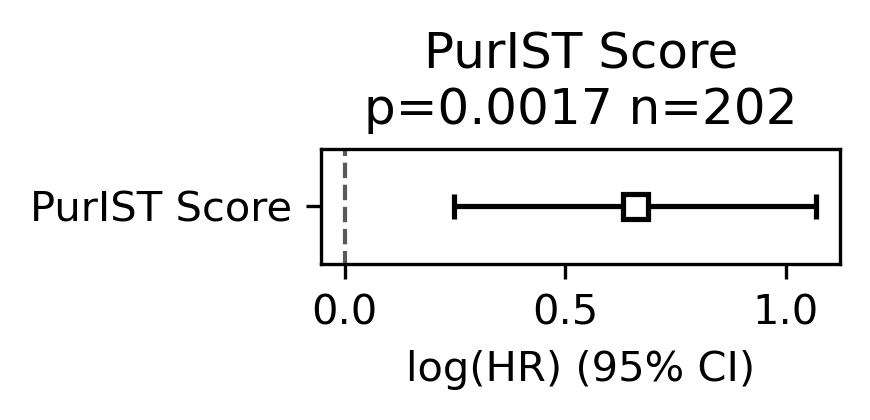

In [16]:
#CPH
%matplotlib inline
df_result=pd.DataFrame()
ls_vital = [#'Neoadjuvant','Age','Sex','Stage', 'Grade','LV_Invasion','LN_Pos', #'Age at Diagnosis',
       'PurIST Score',
          'Recurrence_',
         'Cohort']
#ls_vital = ls_genes
for s_vital in ls_vital:
    print(s_vital)
    df = df_patient.loc[~df_patient.Public_Patient_ID.duplicated(),[s_vital,s_time,s_censor]].dropna(how='any')
    if df.columns.isin(['Stage']).any():
        df.Stage = df.Stage.replace({'I':1,'II':2,'III':3,'IV':4}).astype('int')
    if df.columns.isin(['Grade']).any():
        df.Grade = df.Grade.astype('int')
    if df.loc[:,s_vital].dtype=='O':
        df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
        if s_vital =='Recurrence_':
            df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=False)
            df_dummy.drop('Recurrence__Other_Site',axis=1,inplace=True)
        df.drop(s_vital,axis=1,inplace=True)
        s_vital = df_dummy.columns[0]
        df[s_vital] = df_dummy
    if s_vital.find('_Up_')>-1:
        d_rename = {s_vital:s_vital.split('_Up')[0]}
        df=df.rename(d_rename,axis=1)
        s_vital = s_vital.split('_Up')[0] 
    fig, cph = cph_plot(df,s_vital,s_time,s_censor,figsize=(3,1.5))
    plt.tight_layout()
    if s_vital == 'Recurrence__None':
        s_vital = s_vital + '_' + s_compare_to
    fig.savefig(f'figures/CPH_single_{s_vital}_subset.png')
    df_result=pd.concat([df_result,cph.summary.loc[:,['exp(coef)','p']]])
    break

In [17]:
print(s_vital)
#df_result.index = [s_vital]
df_result

PurIST Score


,exp(coef),p
covariate,,
PurIST Score,1.932506,0.001661


In [18]:
# %matplotlib inline
# ls_drop = df_patient[~df_patient.loc[:,'Patient Specimen ID'].str.contains('-T2').fillna(False)].index
# # check prognostic value of clinicopathologiocal variables
# import lifelines
# from lifelines import KaplanMeierFitter, CoxPHFitter
# from lifelines.statistics import multivariate_logrank_test
# ls_vital = ['Neoadjuvant','Age','Sex','Stage', 'Grade','LV_Invasion','LN_Pos'] 
# ls_vital  = ls_genes
# s_time = 'cDays from Diagnosis to FU'
# s_censor = 'Survival'
# for s_vital in ls_vital:
#     print(s_vital)
#     df = df_patient.loc[df_patient.Stage!='0',[s_vital,s_time,s_censor]].dropna(how='any')
#     df.loc[:,s_vital] = df.loc[:,s_vital].replace({True:'altered',False:'WT'})
#     fig, __ = km_plot(df,s_vital,s_time,s_censor)
#     fig.savefig(f'figures/KM_clinicopath_{s_vital}_subset.png')
#     break
    


## pORG and pSUB gene signature scores

pORG, pSUB GSVA

In [23]:
#df_pORG = pd.read_csv(f'{codedir}/data/GSVA_Scores_Link.csv')#=,index_col='Public_Specimen_ID'
#df_pORG = pd.read_csv(f'{codedir}/20230526_GSVA_Scores.csv')
s_pORG = '0.2'
if s_pORG == '0.2':
    df_pORG = pd.read_csv(f'../20230608_GSVA_Scores.csv')
    df_pORG['Patient Specimen ID'] = df_pORG.Public_Specimen_ID#[item.split('-')[0] + '-' + item.split('-')[1] for item in df_pORG.Public_Specimen_ID]
    df_patient = df_patient.merge(df_pORG[df_pORG.Group=='GSVA_Primary'],on='Patient Specimen ID',suffixes=('',"_x"))
    ls_drop_T2 = df_patient[df_patient.Public_Specimen_ID.str.contains('-T2')].index
    ls_vital = [ 'trim_padj_0.2_pORG_Up_55_Genes','trim_padj_0.2_pSUB_Up_100_Genes',
     #'txi_pORG_Up_42_Genes','Original_pORG_Up_78_Genes','Original_pSUB_Up_100_Genes','txi_pSUB_Up_100_Genes', 
        ]
else:
    df_pORG = pd.read_csv(f'../annotation/GSVA_pORG_0.14_0.15.tsv',sep='\t')
    df_pORG = pd.read_csv(f'../annotation/GSVA_Primaries_Kallisto55_pSUB1e-4and1e-5.tsv',sep='\t')
    #temp: use OPTR
    df_pORG['Patient Specimen ID'] = df_pORG.SampleID.map(dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Public.Specimen.ID'])))
    df_patient = df_patient.merge(df_pORG,on='Patient Specimen ID',suffixes=('',"_x"))
    ls_drop_T2 = df_patient[df_patient.SampleID.str.contains('-T2')].index
    ls_vital = [#'Recurrence_',#'Cohort',
    'PurIST Score','pORG.14', 'pORG.15'
   'Kallisto55_pSUB1e-05', 'Kallisto55_pSUB1e-04',]
df_patient.drop(ls_drop_T2,axis=0,inplace=True)

trim_padj_0.2_pORG_Up_55_Genes


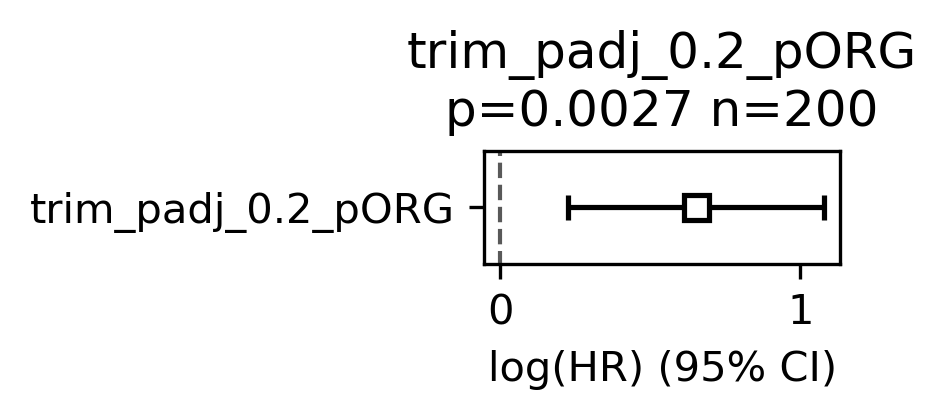

In [24]:
#CPH (primaries only)
df_result=pd.DataFrame()

for s_vital in ls_vital:
    print(s_vital)
    df = df_patient.loc[~df_patient.Public_Patient_ID.duplicated(),[s_vital,s_time,s_censor]].dropna(how='any')
    if df.columns.isin(['Stage']).any():
        df.Stage = df.Stage.replace({'I':1,'II':2,'III':3,'IV':4}).astype('int')
    if df.columns.isin(['Grade']).any():
        df.Grade = df.Grade.astype('int')
    if df.loc[:,s_vital].dtype=='O':
        df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
        if s_vital =='Recurrence_':
            df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=False)
            df_dummy.drop('Recurrence__Other_Site',axis=1,inplace=True)
        df.drop(s_vital,axis=1,inplace=True)
        s_vital = df_dummy.columns[0]
        df[s_vital] = df_dummy
    if s_vital.find('_Up_')>-1:
        d_rename = {s_vital:s_vital.split('_Up')[0]}
        df=df.rename(d_rename,axis=1)
        s_vital = s_vital.split('_Up')[0]
    fig, cph = cph_plot(df,s_vital,s_time,s_censor,figsize=(3,1.5))
    plt.tight_layout()
    fig.savefig(f'figures/CPH_single_{s_vital}_subset_primary.png')
    df_result=pd.concat([df_result,cph.summary.loc[:,['exp(coef)','p']]])
    break

In [25]:
df_result

,exp(coef),p
covariate,,
trim_padj_0.2_pORG,1.918332,0.002745


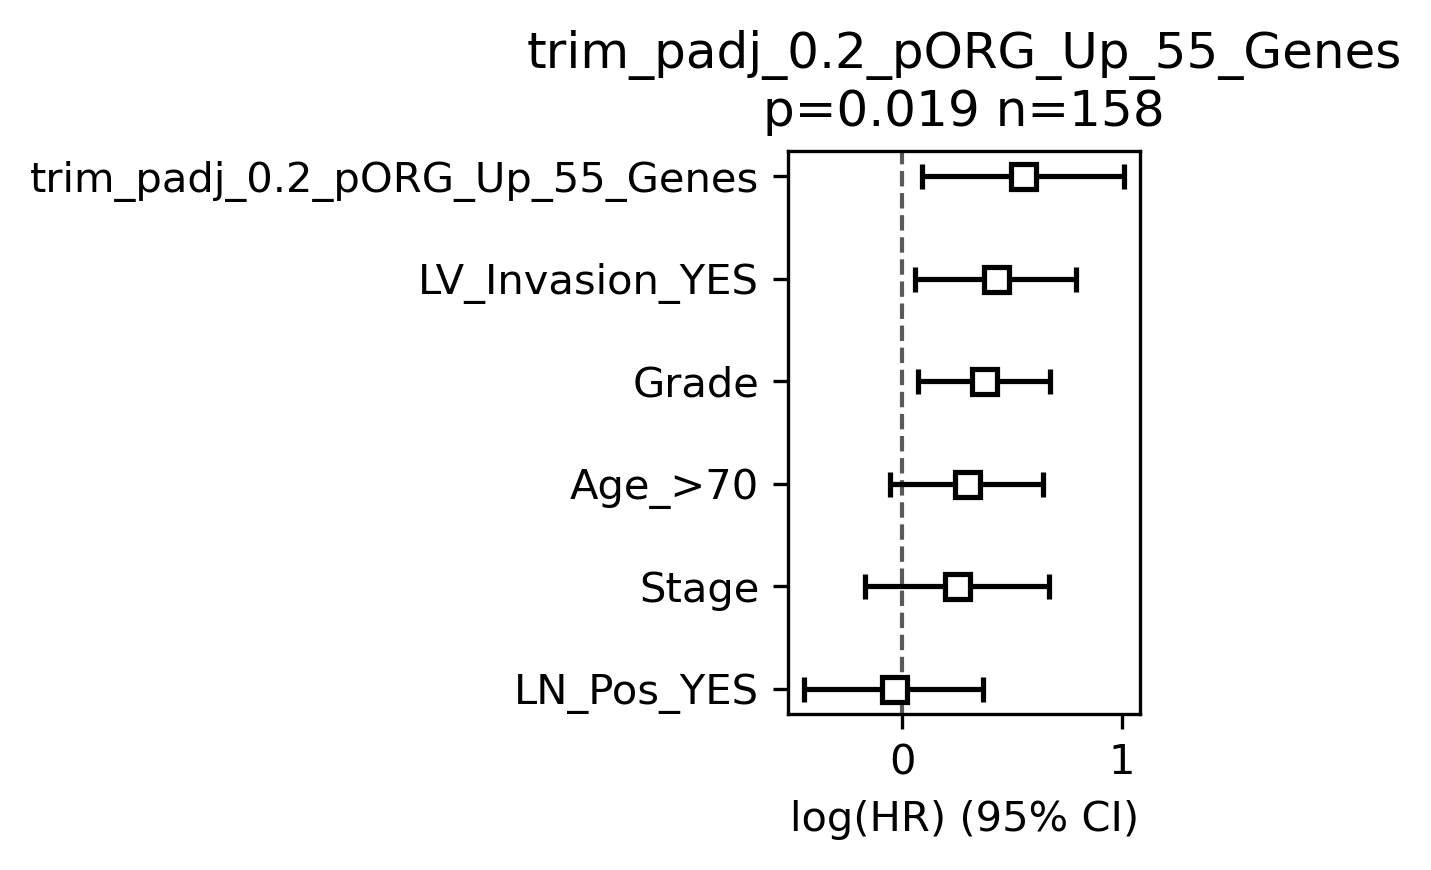

In [28]:
#CPH
df_result_multi = pd.DataFrame()
ls_drop = df_patient[~df_patient.loc[:,'Patient Specimen ID'].str.contains('-T2').fillna(False) & ~df_patient.Public_Patient_ID.duplicated()].index
ls_multi = ls_vital
ls_cats = ['LV_Invasion','LN_Pos','Age'] #
#ls_cats = ['RNF43_altered', 'CDKN2A_altered', 'ARID1B_altered', 'ATM_altered']
for s_multi in ls_multi:
    #why does PurIST have extra patients?
    df = df_patient.loc[ls_drop,[s_multi,s_time,s_censor,'Grade','Stage']].dropna() ##'Neoadjuvant','Age at Diagnosis'
    if ls_cats[0].find('altered') > -1:
        df = df_patient.loc[ls_drop,[s_multi,s_time,s_censor]].dropna()
    if df.loc[:,s_multi].dtype=='O':
        df_dummy = pd.get_dummies(df.loc[:,[s_multi]],drop_first=True)
        if s_multi =='Recurrence_':
            df_dummy = pd.get_dummies(df.loc[:,[s_multi]],drop_first=False)
            df_dummy.drop('Recurrence__Other_Site',axis=1,inplace=True)
        df.drop(s_multi,axis=1,inplace=True)
        s_multi = df_dummy.columns[0]
        df[s_multi] = df_dummy
    df_dummy = pd.get_dummies(df_patient.loc[:,ls_cats],drop_first=True) #'TP53_altered','CDKN2A_altered',,'Sex'
    df = pd.concat([df,df_dummy],axis=1)
    fig, cph = cph_plot(df,s_multi,s_time,s_censor,figsize=(4,3))
    if s_multi == 'Recurrence__None':
        s_multi = s_multi + '_' + s_compare_to
    fig.savefig(f'figures/CPH_multi_{s_multi}.png')
    df_result_multi=pd.concat([df_result_multi,cph.summary.loc[:,['exp(coef)','p']]])
    break

In [29]:
df_result_multi

,exp(coef),p
covariate,,
trim_padj_0.2_pORG_Up_55_Genes,1.732694,0.019406
Grade,1.454492,0.014657
Stage,1.284610,0.242987
LV_Invasion_YES,1.531872,0.022380
LN_Pos_YES,0.963703,0.858844
Age_>70,1.343148,0.096216


In [32]:
#save out the metadata
ls_drop = ['Liver Met Present in Patient tumor',
       'Lung Met Present in Patient tumor','Lung Met Present in Patient blood',
       'Liver Met Present in Patient blood',#'Unnamed: 0',
           'pORG_Primary',
 'pSUB_Primary','OPTR','SampleID'#'OPTR',
          ]
#save out
s_out = 'Patient_metadata_clean_20.csv'#'Patient_metadata_clean.csv'
if not os.path.exists(s_out):
    print('saving')
    df_patient.loc[:,~df_patient.columns.isin(ls_drop)].to_csv(s_out)

saving


# Section 6 <a name="geneexp"></a>

gene expresison correlation

The 7 genes used for the IRDS signature were: STAT1, IFI44, IFIT3, OAS1,208
IFIT1, G1P2, and MX1


[contents](#contents)

In [39]:
s_out = 'Patient_metadata_clean_20.csv'
df_patient= pd.read_csv(s_out,index_col=0)

df_vst = pd.read_csv('data/VST_Genes_Link.csv',index_col=0)
df_rna = df_vst.T.copy()
df_rna.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ZBED1,RNA5SP498,TRPC6P,DHRSX-IT1,CD99P1,LINC00685,ASMTL-AS1,LINC00106,AMD1P2,AJ271736.10
ST-00006625-T,8.999777,5.615138,10.290799,10.833471,9.825571,10.076949,13.834674,11.121776,10.220602,10.258728,...,10.417358,4.16136,4.16136,4.16136,4.161360,4.16136,5.781611,4.16136,4.461028,4.756400
ST-00007302-T,8.694857,5.590743,10.031410,9.940410,9.469403,9.488957,13.549948,11.269591,9.987760,10.346659,...,11.519658,4.16136,4.16136,4.16136,4.540466,4.16136,5.696210,4.16136,4.161360,5.078557
ST-00015839-T,8.972040,5.901941,9.855278,10.471976,9.454899,10.554598,13.709351,10.202933,9.982841,10.174168,...,9.998972,4.16136,4.16136,4.16136,4.161360,4.16136,6.641563,4.16136,4.161360,4.597239
ST-00020117-T,8.557646,5.266535,9.803305,10.584020,9.127125,9.190413,13.958330,10.906235,10.814091,10.035815,...,10.378406,4.16136,4.16136,4.16136,4.161360,4.16136,6.557239,4.16136,4.161360,4.875396
ST-00016213-T,7.687182,4.729227,9.619395,10.322167,8.794384,9.605110,11.167533,10.571125,9.628891,9.113417,...,11.709445,4.16136,4.16136,4.16136,4.161360,4.16136,6.935822,4.16136,4.161360,4.965787


In [40]:
#df_pORG = pd.read_csv(f'{codedir}/data/GSVA_Scores_Link.csv')#=,index_col='Public_Specimen_ID'
#df_pORG = pd.read_csv(f'{codedir}/20230526_GSVA_Scores.csv')
if s_pORG == '0.2':
    df_pORG = pd.read_csv(f'../20230608_GSVA_Scores.csv',index_col=0)
    df_pORG['Patient Specimen ID'] = df_pORG.Public_Specimen_ID
    ls_add = ['trim_padj_0.2_pORG_Up_55_Genes','trim_padj_0.2_pSUB_Up_100_Genes',]
    s_primary_all = 'GSVA_Primary'#'GSVA_All'#
    for s_add in ls_add:
        d_map = dict(zip(df_pORG.loc[df_pORG.Group==s_primary_all,'Patient Specimen ID'],df_pORG.loc[df_pORG.Group=='GSVA_Primary',s_add]))
        df_rna[s_add] = df_rna.index.map(d_map)
else:
    #temp: use OPTR
    df_pORG = pd.read_csv(f'../annotation/GSVA_pORG_0.14_0.15.tsv',sep='\t')
    df_pORG['Patient Specimen ID'] = df_pORG.SampleID.map(dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Public.Specimen.ID'])))
    ls_add = ['pORG.14', 'pORG.15']
    for s_add in ls_add:
        d_map = dict(zip(df_pORG.loc[:,'Patient Specimen ID'],df_pORG.loc[:,s_add]))
        df_rna[s_add] = df_rna.index.map(d_map)
df_pORG.head()

,Sample,Original_pORG_Up_78_Genes,Original_pSUB_Up_100_Genes,Original_pSUB_Up_362_Genes,padj_0.2_pORG_Up_38_Genes,padj_0.2_pSUB_Up_100_Genes,padj_0.2_pSUB_Up_682_Genes,trim_padj_0.2_pORG_Up_55_Genes,trim_padj_0.2_pSUB_Up_100_Genes,trim_padj_0.2_pSUB_Up_888_Genes,...,txi_pSUB_Up_816_Genes,bam_padj_0.2_pORG_Up_129_Genes,bam_padj_0.2_pSUB_Up_100_Genes,bam_padj_0.2_pSUB_Up_899_Genes,bam_padj_0.1_pORG_Up_29_Genes,bam_padj_0.1_pSUB_Up_100_Genes,bam_padj_0.1_pSUB_Up_566_Genes,Public_Specimen_ID,Group,Patient Specimen ID
0,3086-T,-0.560479,-0.531725,-0.517834,-0.617030,-0.531725,-0.512330,-0.595686,-0.529248,-0.514325,...,-0.491341,-0.525443,-0.490028,-0.478009,-0.531759,-0.490028,-0.490027,ST-00007061-T,GSVA_Primary,ST-00007061-T
1,3087-T,0.196250,-0.311447,-0.328836,0.081238,-0.311447,-0.296183,0.128287,-0.355990,-0.281358,...,-0.270346,0.198793,-0.385257,-0.229336,0.369992,-0.385257,-0.298054,ST-00007067-T,GSVA_Primary,ST-00007067-T
2,3097-T,0.588168,0.561702,0.499764,0.600515,0.561702,0.455948,0.595160,0.565872,0.469347,...,0.471663,0.588891,0.583603,0.472547,0.567472,0.583603,0.503736,ST-00007071-T,GSVA_Primary,ST-00007071-T
3,3105-T,0.436819,-0.248080,-0.340031,0.411854,-0.248080,-0.343937,0.434770,-0.300647,-0.348668,...,-0.332015,0.465241,-0.254239,-0.337684,0.581742,-0.254239,-0.360451,ST-00007085-T,GSVA_Primary,ST-00007085-T
4,3117-T,0.058052,0.392718,0.313612,-0.167399,0.392718,0.324258,-0.223434,0.388680,0.355622,...,0.338490,0.160263,0.412338,0.356217,-0.251470,0.412338,0.347186,ST-00007099-T,GSVA_Primary,ST-00007099-T


204
204


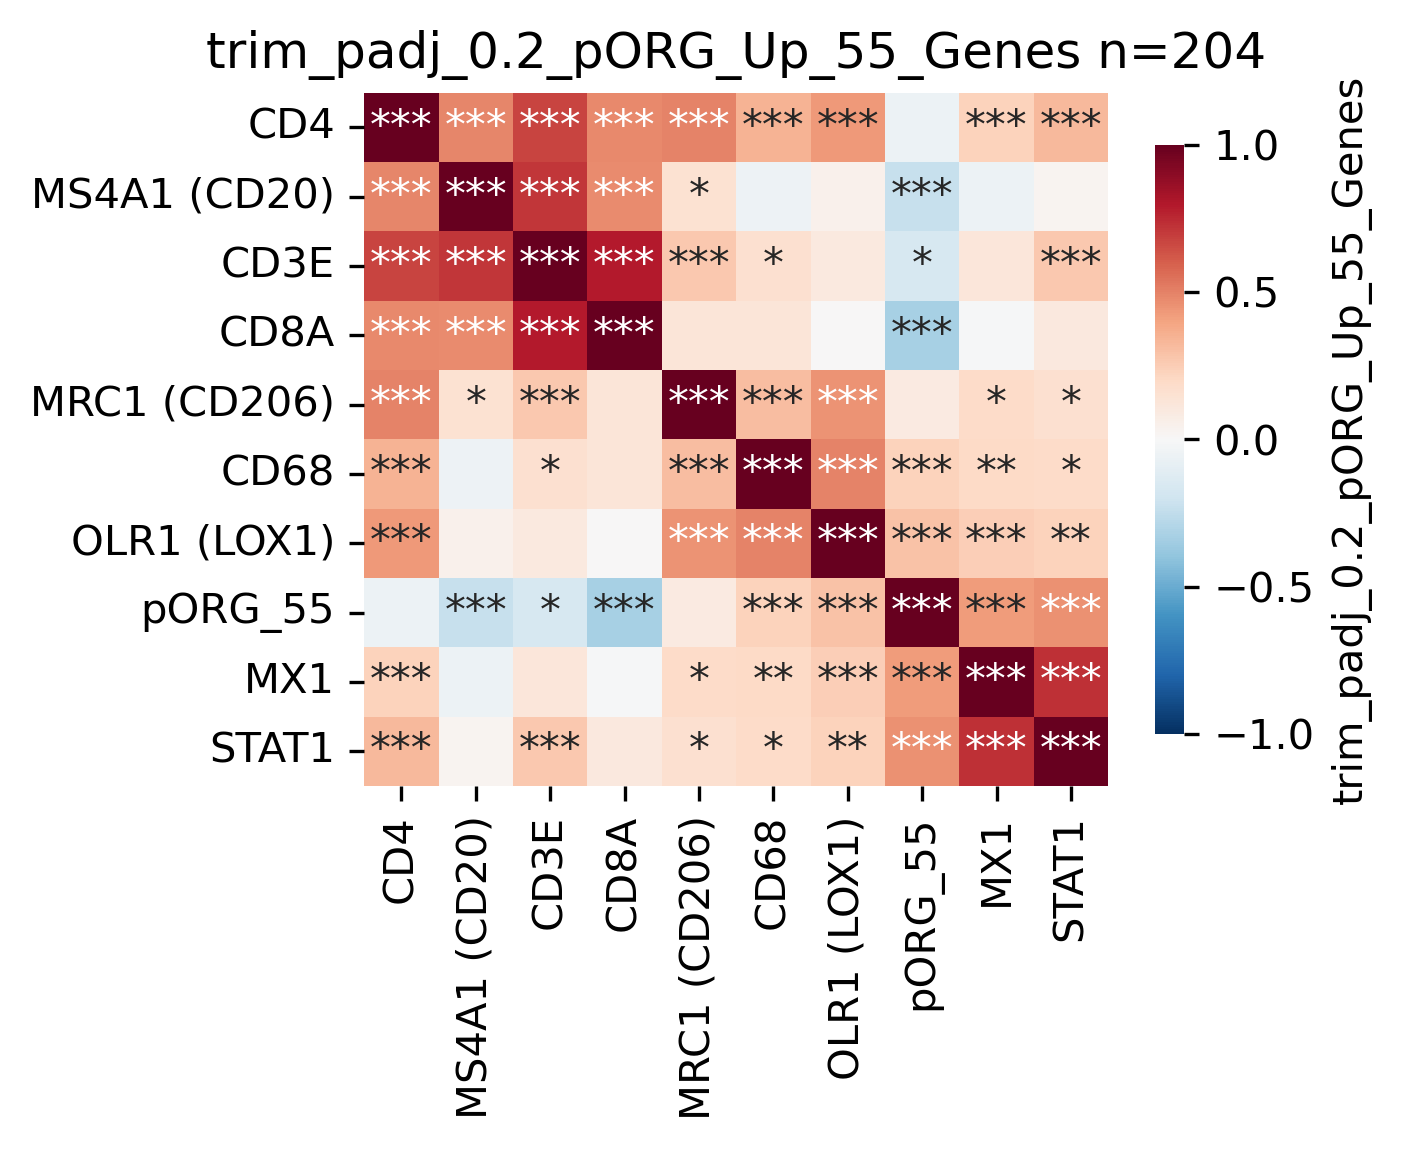

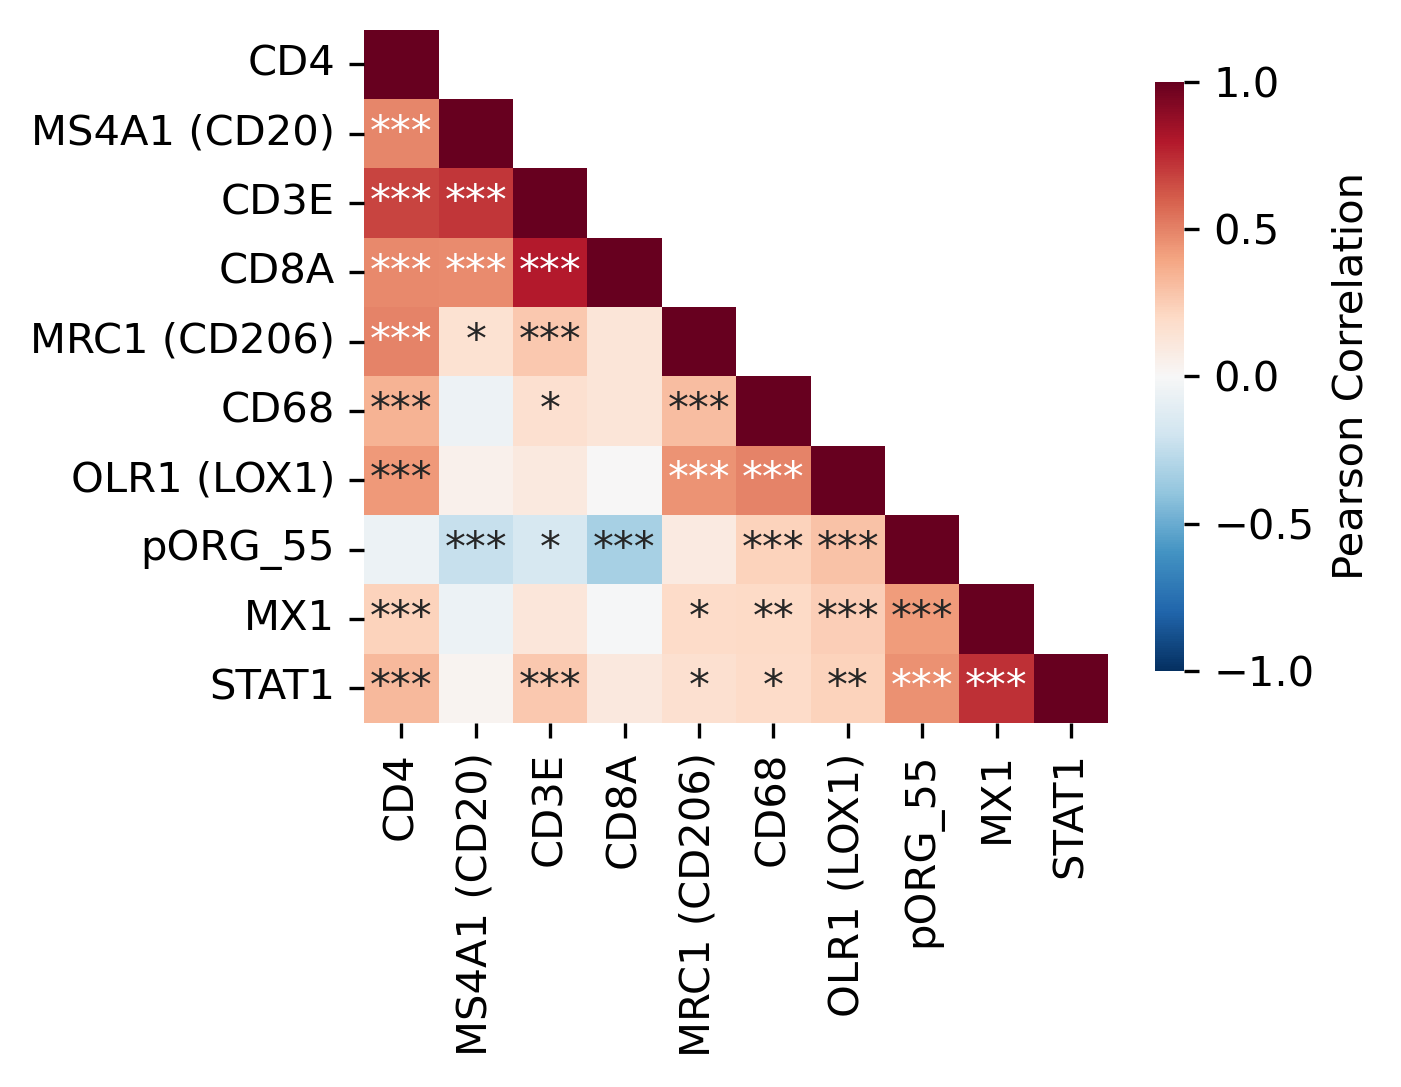

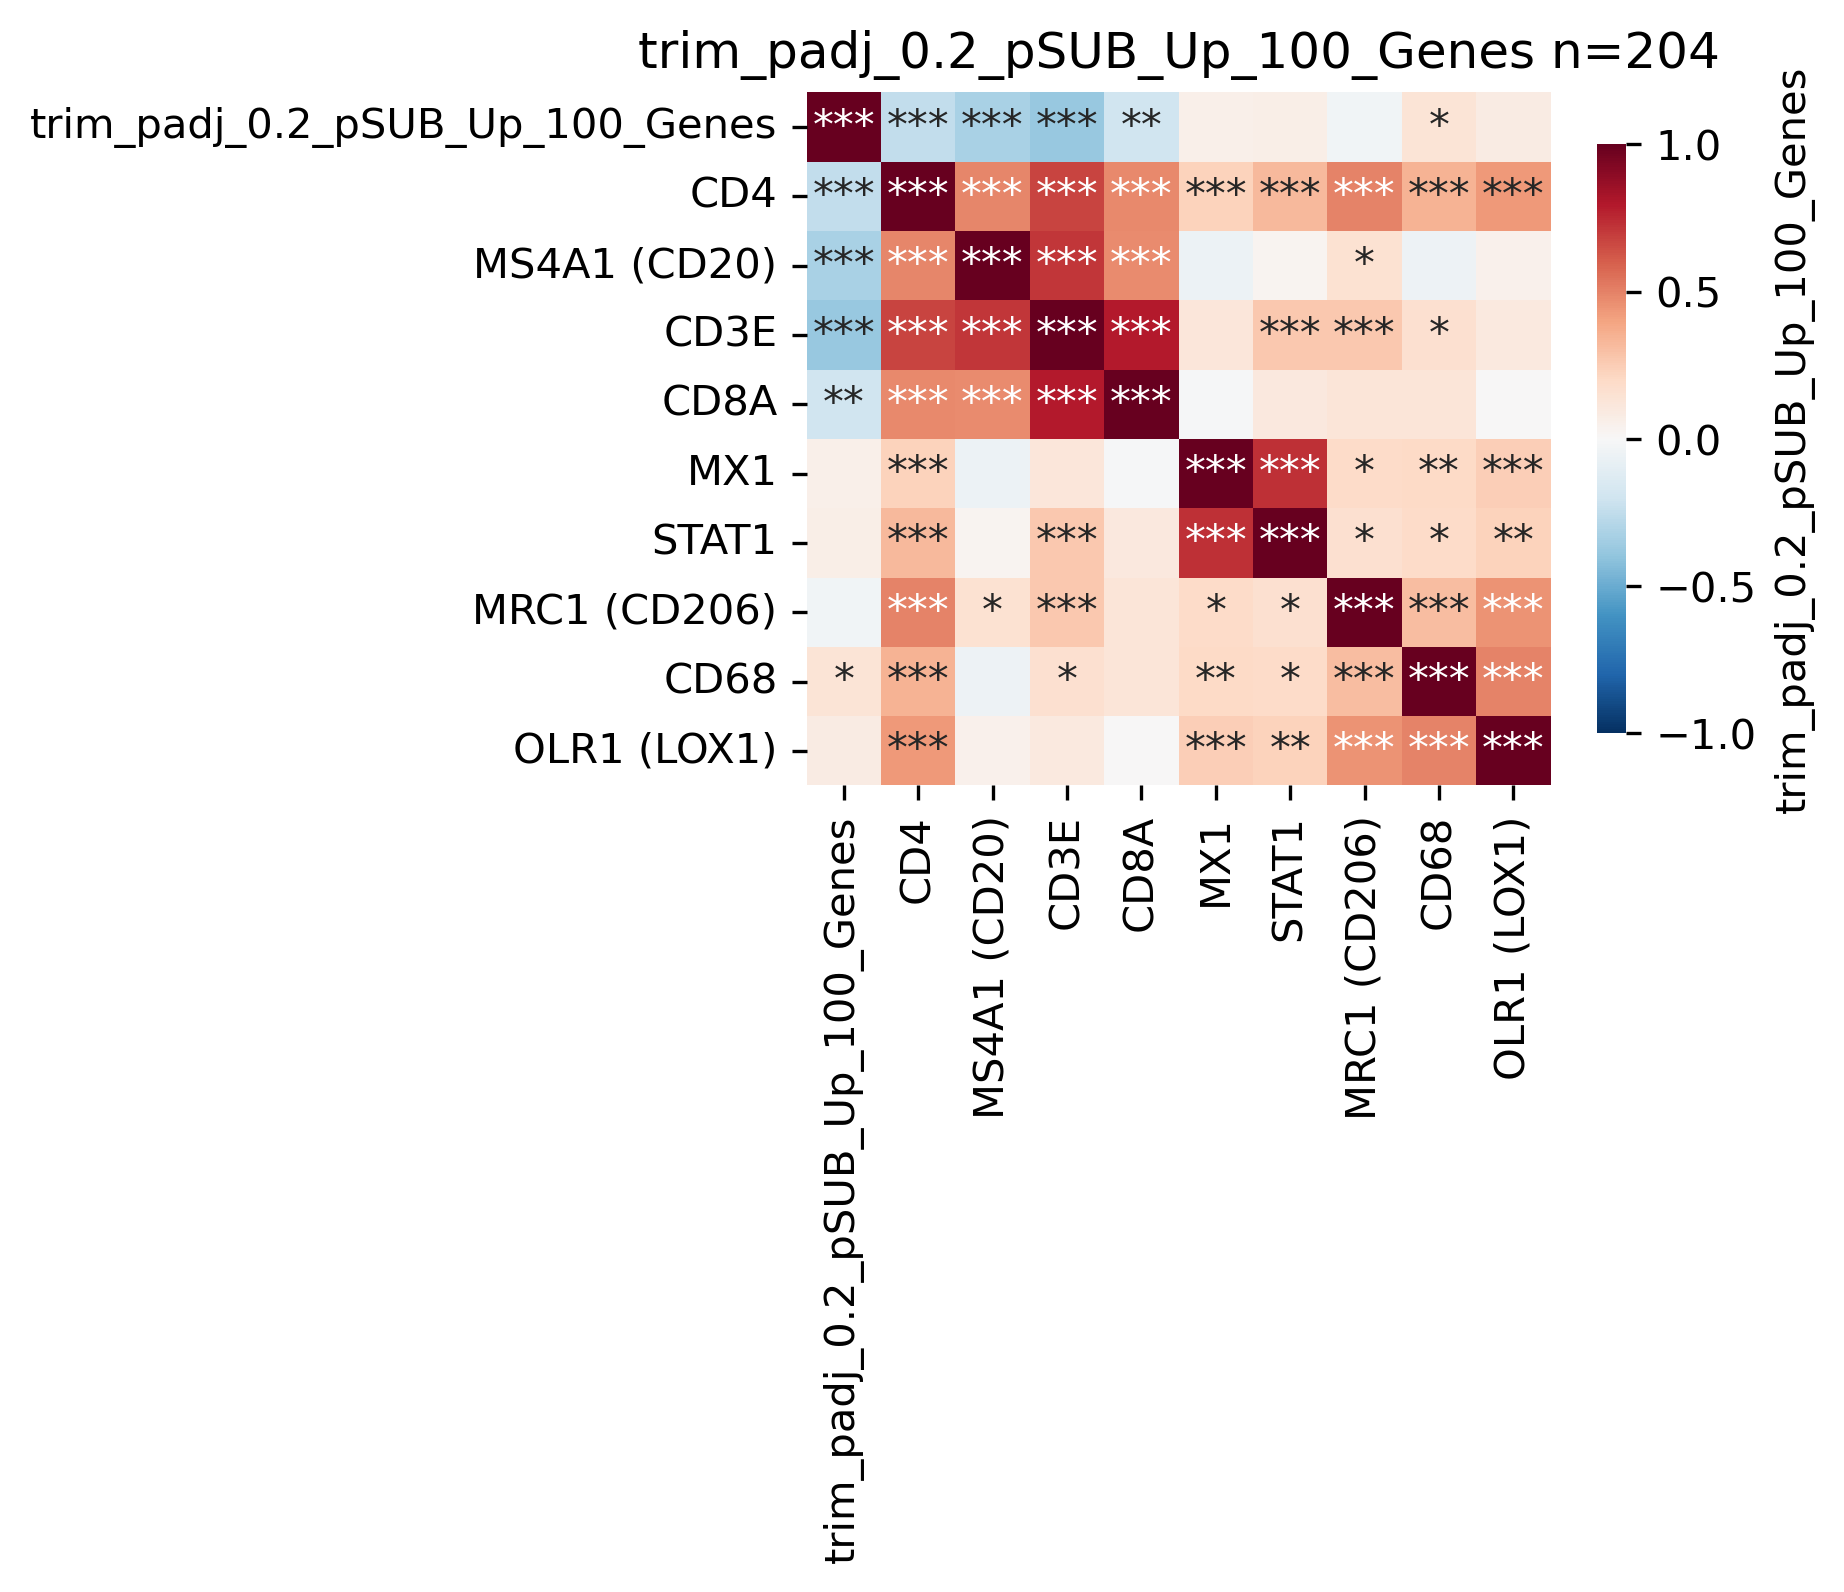

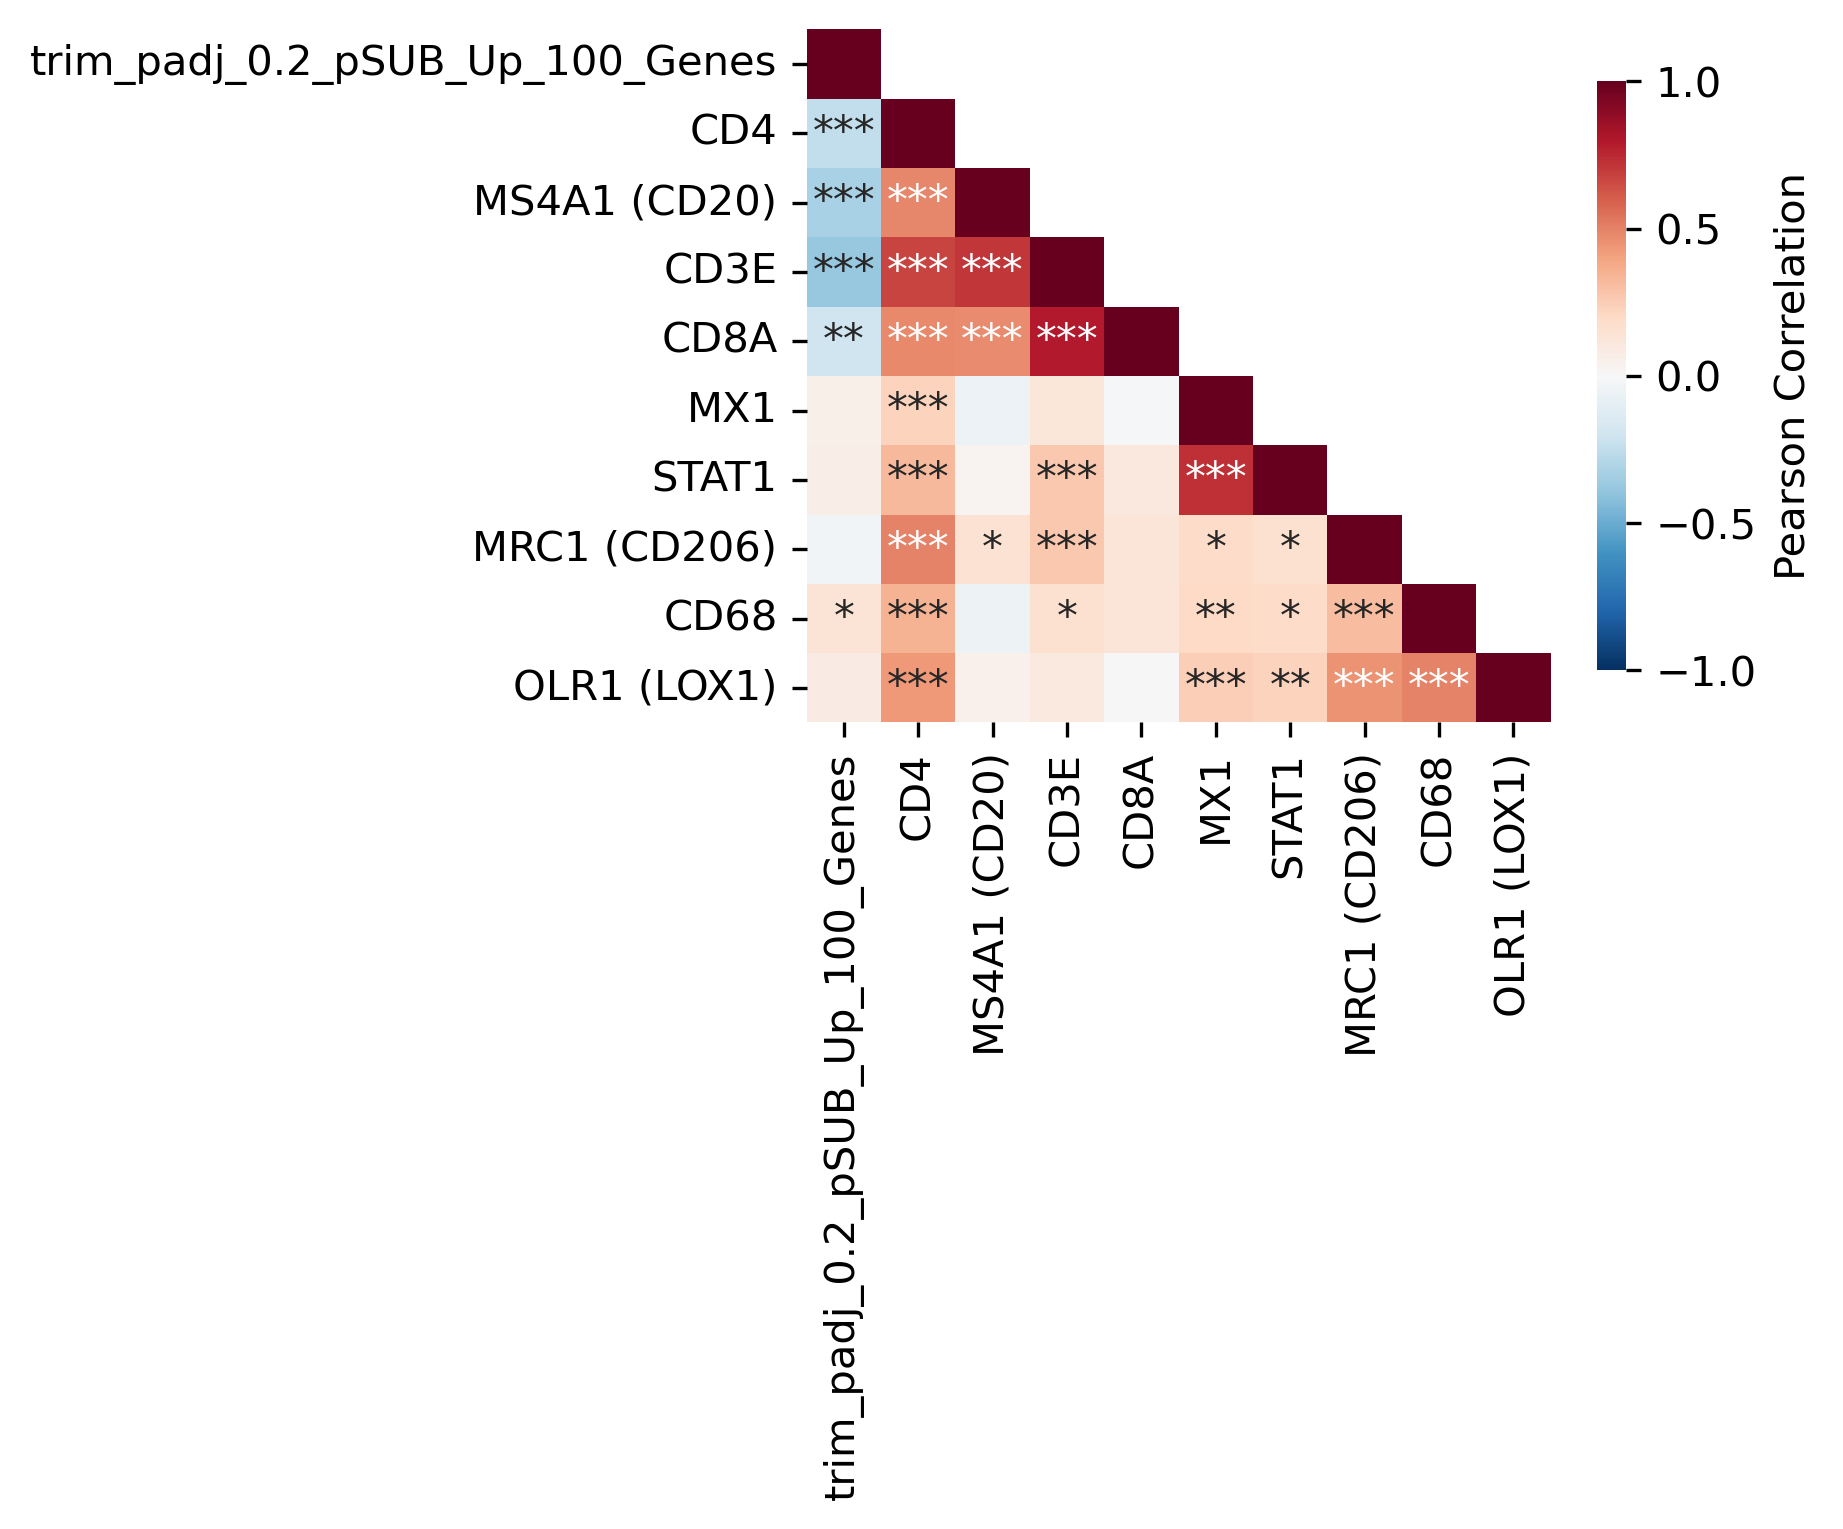

In [41]:
%matplotlib inline
d_rename={'txi_pORG_Up_42_Genes':'pORG_42',
          'trim_padj_0.2_pORG_Up_55_Genes':'pORG_55',
          'pORG.14':'pORG_14', 'pORG.15':'pORG_15',
          'MRC1':'MRC1 (CD206)',
          'OLR1':'OLR1 (LOX1)',
          'MS4A1':'MS4A1 (CD20)'}
from scipy.stats import pearsonr
dim = (4,3)
    
for s_add in ls_add:
    ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1',#'LAMP3','ITGAX','CD209',
                 'CD68','OLR1','MRC1','MX1','STAT1',
                 s_add] #
    df_all = df_rna.loc[:,ls_marker].corr().rename(d_rename,axis=1).rename(d_rename,axis=0)
    print(len(df_rna))
    g = sns.clustermap(df_all)
    plt.close()
    categories_order = df_all.iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
    df_all = df_all.loc[categories_order,categories_order]
    rho = df_rna.loc[:,ls_marker].corr() #df_all.corr()
    pval = df_rna.loc[:,ls_marker].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
    p_vals = p_vals.rename(d_rename,axis=1).rename(d_rename,axis=0)
    p_vals = p_vals.loc[categories_order,categories_order]
    fig, ax = plt.subplots(figsize=dim,dpi=300)
    sns.heatmap(df_all, vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax,
               cbar_kws={'shrink':0.85,'label':s_add})
    #plt.title(f'{s_primary_all} n={len(df_rna)}')
    #temp
    plt.title(f'{s_add} n={len(df_rna)}')
    #ax.set_title(f'Cell Type versus Scores', fontdict={'fontsize':16}, pad=12);
    #fig.savefig(f'{codedir}/{s_date}/heatmap_Celltype_vs_pORG_purIST.png', dpi=300, bbox_inches='tight')
    #'''
    fig, ax = plt.subplots(figsize=dim,dpi=300)
    matrix = np.triu(np.ones_like(rho))
    np.fill_diagonal(matrix, val=0)
    np.fill_diagonal(p_vals.values,'')
    sns.heatmap(df_all, vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',
                ax=ax,mask=matrix,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'},
               ) #'anchor':(-1.4,0.0)
    #'''
    #pval
    #break

In [42]:
df_patient = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1_age.xlsx',
                           sheet_name='Patients - Tab 1')
df_patient.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
df_patient.loc[df_patient.loc[:,'Lung Met Present']=='YES','Cohort'] = 'Lung'
df_patient.loc[df_patient.loc[:,'Liver Met Present']=='YES','Cohort'] = 'Liver'

df_rna['Public_Patient_ID'] = [item[0:-2] for item in df_rna.index]
df_rna['Cohort'] = df_rna.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))

## gene expresison versus liver lung

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

STAT1_Lung vs. STAT1_Liver: t-test independent samples, P_val:6.457e-02 t=-1.878e+00
CD4_Lung vs. CD4_Liver: t-test independent samples, P_val:7.907e-01 t=2.664e-01
CD3E_Lung vs. CD3E_Liver: t-test independent samples, P_val:4.354e-01 t=7.844e-01
CD8A_Lung vs. CD8A_Liver: t-test independent samples, P_val:7.640e-01 t=3.014e-01
MS4A1_Lung vs. MS4A1_Liver: t-test independent samples, P_val:1.941e-01 t=1.311e+00
CD68_Lung vs. CD68_Liver: t-test independent samples, P_val:9.468e-01 t=-6.692e-02
OLR1_Lung vs. OLR1_Liver: t-test independent samples, P_val:1.194e-01 t=-1.577e+00
MRC1_Lung vs. MRC1_Liver: t-test independent samples, P_val:3.247e-01 t=-9.918e-01
MX1_Lung vs. MX1_Liver: t-test independent samples, P_val:9.057e-02 t=-1.716e+00


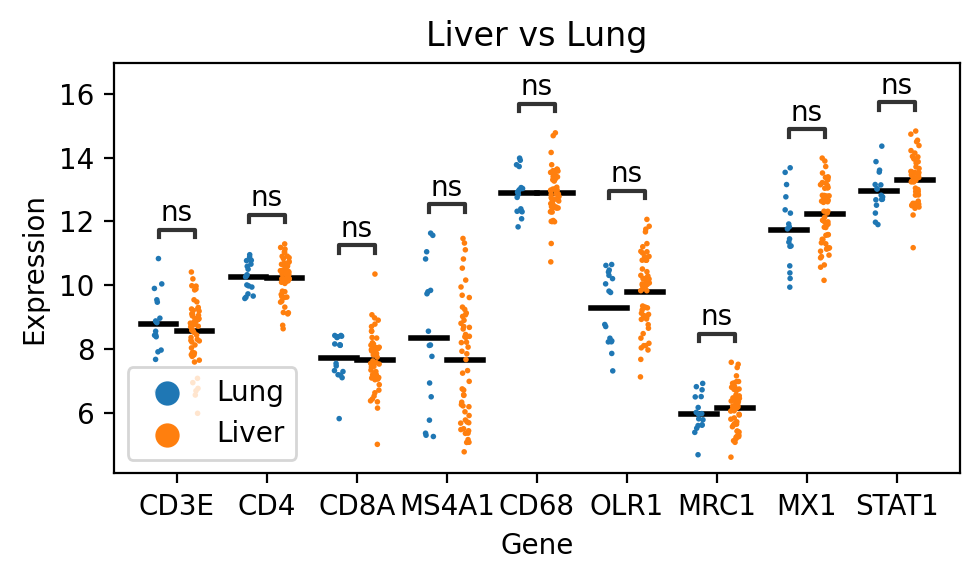

In [43]:
#liver vs lung (run t cell section to load t cell data)
ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1','CD68','OLR1','MRC1','MX1','STAT1',]
df_plot = df_rna.loc[df_rna.Public_Patient_ID.isin(df_tcell.Public_Patient_ID),ls_marker].unstack().reset_index()
df_plot = df_rna.loc[:,ls_marker].unstack().reset_index()
df_plot['Public_Patient_ID'] = [item[0:-2] for item in df_plot.level_1]
df_plot['Cohort'] = df_plot.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
df_plot.rename({0:'Expression','level_0':'Gene'},axis=1,inplace=True)
fig,ax = plt.subplots(dpi=200,figsize=(5,3))
sns.stripplot(data=df_plot,x='Gene',y='Expression',hue='Cohort',dodge=True,ax=ax,s=2)
sns.boxplot(data=df_plot,x='Gene',y='Expression',hue='Cohort',ax=ax,showmeans=True,medianprops={'visible': False},
                       whiskerprops={'visible': False},meanline=True,showcaps=False,
                       meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2],l[0:2],loc='lower left')
pairs = [((item,'Lung'),(item,'Liver')) for item in ls_marker]
annot = Annotator(ax, pairs, data=df_plot,x='Gene',y='Expression',hue='Cohort',
                  order=ls_marker,hue_order=('Lung','Liver'))
annot.configure(test='t-test_ind')
annot.apply_and_annotate()
ax.set_title(f'Liver vs Lung')
plt.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

STAT1_Lung vs. STAT1_Liver: t-test independent samples, P_val:5.587e-02 t=-1.962e+00
CD4_Lung vs. CD4_Liver: t-test independent samples, P_val:6.386e-01 t=4.728e-01
CD3E_Lung vs. CD3E_Liver: t-test independent samples, P_val:9.359e-01 t=-8.092e-02
CD8A_Lung vs. CD8A_Liver: t-test independent samples, P_val:6.688e-01 t=-4.306e-01
MS4A1_Lung vs. MS4A1_Liver: t-test independent samples, P_val:7.906e-01 t=2.671e-01
CD68_Lung vs. CD68_Liver: t-test independent samples, P_val:7.663e-01 t=2.990e-01
OLR1_Lung vs. OLR1_Liver: t-test independent samples, P_val:5.390e-02 t=-1.978e+00
MRC1_Lung vs. MRC1_Liver: t-test independent samples, P_val:1.305e-01 t=-1.540e+00
MX1_Lung vs. MX1_Liver: t-test independent samples, P_val:1.199e-01 t=-1.585e+00


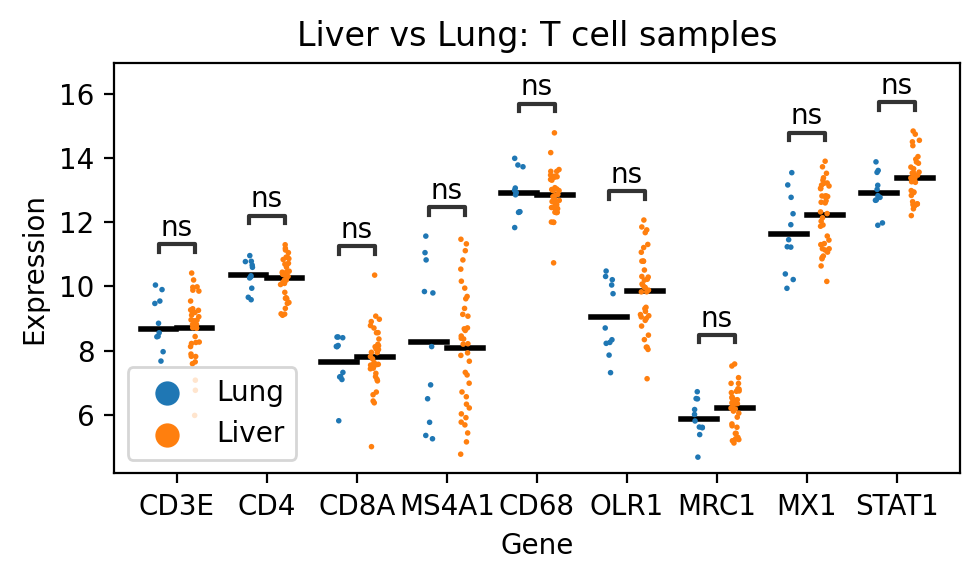

In [44]:
#liver vs lung (run t cell section to load t cell data)
ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1','CD68','OLR1','MRC1','MX1','STAT1',]
df_plot = df_rna.loc[df_rna.Public_Patient_ID.isin(df_tcell.Public_Patient_ID),ls_marker].unstack().reset_index()
#df_plot = df_rna.loc[:,ls_marker].unstack().reset_index()
df_plot['Public_Patient_ID'] = [item[0:-2] for item in df_plot.level_1]
df_plot['Cohort'] = df_plot.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
df_plot.rename({0:'Expression','level_0':'Gene'},axis=1,inplace=True)
fig,ax = plt.subplots(dpi=200,figsize=(5,3))
sns.stripplot(data=df_plot,x='Gene',y='Expression',hue='Cohort',dodge=True,ax=ax,s=2)
sns.boxplot(data=df_plot,x='Gene',y='Expression',hue='Cohort',ax=ax,showmeans=True,medianprops={'visible': False},
                       whiskerprops={'visible': False},meanline=True,showcaps=False,
                       meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2],l[0:2],loc='lower left')
pairs = [((item,'Lung'),(item,'Liver')) for item in ls_marker]
annot = Annotator(ax, pairs, data=df_plot,x='Gene',y='Expression',hue='Cohort',
                  order=ls_marker,hue_order=('Lung','Liver'))
annot.configure(test='t-test_ind')
annot.apply_and_annotate()
ax.set_title(f'Liver vs Lung: T cell samples')
plt.tight_layout()

## Section 6 <a name="tcell"></a>

re-analyze t cell data

289 blood samples with matching 175 primary
tumors (141 overlapping with the RNA-seq dataset) and 43 metastatic tumors (33 overlapping with
the RNA-seq dataset). (218)

**missing 2 tumor, all 289 blood there**

TOTAL = 174

(total pORG = 171)


we analyzed blood samples from 77 patients in the liver cohort and 16
patients in the lung cohort, of which 60 and 16 were matched with tumor samples from the same
patient, respectively

TOTAL = 94 blood
TOTAL = 76 tumor

tumor distinct clones
used data from 214 matched pairs of tumor and blood samples

**213 are there, missing 1**

(TCR tumor: 59 and 16)


[contents](#contents)

In [129]:
#load full patient data, neoadjuvant
from scipy.stats import f_oneway
df_patient = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx',
                           sheet_name='Patients - Tab 1')
df_patient.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
df_patient.loc[df_patient.loc[:,'Lung Met Present']=='YES','Cohort'] = 'Lung'
df_patient.loc[df_patient.loc[:,'Liver Met Present']=='YES','Cohort'] = 'Liver'

#df_patient['Public.Specimen.ID'] = [item + '-T' for item in df_patient.loc[:,'Patient ID']]

#neo
df_patient.loc[:,'Neoadjuvant Treatment'].unique()
df_patient.loc[df_patient.loc[:,'Neoadjuvant Treatment'] == 'Yes Neoadjuvant','Neoadjuvant'] = 'Yes'
df_patient['Neoadjuvant'] = df_patient.Neoadjuvant.fillna('No')
#censored
df_patient['Survival'] = df_patient.loc[:,'Vital Status at FU'].replace({'Alive':0,'Dead':1})

#has a recurrence, not in liver or lung
b_recur = ~df_patient.loc[:,'Days from Resection to Recurrence'].isna() & df_patient.Cohort.isna() 

#had a resection, no recurrence,  not liver or lung
b_no_recur = ~df_patient.loc[:,'Days from Resection to FU'].isna() & df_patient.loc[:,'Days from Resection to Recurrence'].isna()  & df_patient.Cohort.isna() 

#add recurrence other/none
df_patient['Other_Recurrence'] = False
df_patient.loc[b_recur,'Other_Recurrence'] = True

df_patient['No_Recurrence'] = False
df_patient.loc[b_no_recur,'No_Recurrence'] = True

#load T cell data
df_tcell = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
                         sheet_name='Tumor Samples')
print(len(df_tcell))

df_tcell_blood = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
                         sheet_name='Blood Samples')
print(len(df_tcell_blood))
#both
df_tcell = df_tcell.merge(df_tcell_blood,on='Patient ID',suffixes=(' tumor',' blood'),how='outer')

df_tcell.rename({'Productive Rearrangements (Observed Richness)':'Productive_Rearrangements',
                'Templates per ng':'Templates_per_ng','Patient ID':'Public_Patient_ID'},axis=1,inplace=True)


#load pSUB, pORG
df_gsva = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx', sheet_name='GSVA Scores - Tab 3')
df_gsva.rename({'pSUB\nPrimaries':'pSUB_Primary','pORG\nPrimaries':'pORG_Primary','pSUB\nAll':'pSUB_All',
                'pORG\nAll':'pORG_All',
                'Patient Specimen ID':'Patient_Specimen_ID'},axis=1,inplace=True)

# # #FNA #changes to 34 high
# ls_fna = df_gsva.Patient_Specimen_ID[df_gsva.Patient_Specimen_ID.str.contains('-F')]
# ls_fna_pt = [item.split('-F')[0] for item in ls_fna]
# ls_fna_index = df_tcell.loc[(df_tcell.Public_Patient_ID.isin(ls_fna_pt)) & (df_tcell.loc[:,'Tumor Type'].isna()),:].index
# df_tcell.loc[ls_fna_index,'Tumor Type'] = '-F'

#met or primary
df_tcell['Type_TM'] = df_tcell.loc[:,'Tumor Type'].replace({'Primary':'-T', 'Met':'-M'})
df_tcell['Patient_Specimen_ID'] = df_tcell.Public_Patient_ID + df_tcell.Type_TM

df_tcell['Cohort'] = df_tcell.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
for s_cat in ['pORG_Primary','pSUB_Primary','pSUB_All','pORG_All']:
    df_tcell[s_cat] = df_tcell.Patient_Specimen_ID.map(dict(zip(df_gsva.Patient_Specimen_ID,df_gsva.loc[:,s_cat])))

# load purIST
df_gsva = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx', sheet_name='Specimen Subtype - Tab 2')
df_gsva.rename({'Patient Specimen ID':'Patient_Specimen_ID'},axis=1,inplace=True)
for s_cat in ['PurIST Subtype']:
    df_tcell[s_cat] = df_tcell.Patient_Specimen_ID.map(dict(zip(df_gsva.Patient_Specimen_ID,df_gsva.loc[:,s_cat])))
    
df_merge = df_tcell.copy()


216
289


In [130]:
# set group
s_porg_group = 'GSVA_All'# 290#  'GSVA_Primary' #218 #'GSVA_Met'# 

if s_pORG == '0.2':
    df_new = pd.read_csv(f'../20230608_GSVA_Scores.csv') #20230608 #20230526
    df_new['Patient_Specimen_ID'] = df_new.Public_Specimen_ID
    ls_merge = ['trim_padj_0.2_pORG_Up_55_Genes','trim_padj_0.2_pSUB_Up_100_Genes', 'Patient_Specimen_ID']#'txi_pORG_Up_42_Genes', 'txi_pSUB_Up_100_Genes',
    df_merge = df_merge.merge(df_new.loc[df_new.Group==s_porg_group,ls_merge],on='Patient_Specimen_ID',how='left')
else:
    #temp: use OPTR
    df_new = pd.read_csv(f'../annotation/{s_porg_group}_pORG_0.14_0.15.tsv',sep='\t')
    df_new['Patient_Specimen_ID'] = df_new.SampleID.map(dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Public.Specimen.ID'])))
    ls_merge = ['pORG.14', 'pORG.15','Patient_Specimen_ID']
    df_merge = df_merge.merge(df_new.loc[:,ls_merge],on='Patient_Specimen_ID',how='left')



## add calculated Entropy, simpsons 

In [131]:
#load data

d_load = {'TCR_Tumor_Distinct_Clones_no_rare.csv':['Public_Patient_ID',
                'Number Tumor Distinct Clones', 'Fraction Tumor Distinct Clones','Prod. Freq. Tumor Distinct Clones'],
          'TCR_Tumor_Distinct_Rearrangements_no_rare.csv':['Public_Patient_ID',
        'Number Tumor Distinct Rearrangements','Fraction Tumor Distinct Rearrangements','Prod. Freq. Tumor Distinct Rearrangements'],
          'TCR_Tumor_Distinct_Clones.csv':['Public_Patient_ID','Number Tumor Distinct Clones (rare)','Fraction Tumor Distinct Clones (rare)'],
          'TCR_Simpsons_Evenness_templates.csv':['Public_Patient_ID','Simpsons_Evenness','Simpsons_Evenness_no_CMV'],
          'TCR_Simpsons_D_templates.csv':['Public_Patient_ID','Simpsons_D'],
          'TCR_Shannon_entropy_productive_frequency.csv':['Public_Patient_ID','Shannon_Entropy','Normalized_Shannon_Entropy'],
         }
for s_en, ls_markers in d_load.items():
    print(s_en)
    df_en = pd.read_csv(s_en)
    df_en.rename({'Unnamed: 0':'Patient_Specimen_ID','Shannon Entropy':'Shannon_Entropy',#'Percent Tumor Distinct Rearrangements in Tumor':'Percent Tumor Distinct Clones (JL)',   
             'Normalized Shannon Entropy':'Normalized_Shannon_Entropy'},axis=1,inplace=True)
    if s_en == 'TCR_Tumor_Distinct_Clones.csv':
        df_en.rename({'Unnamed: 0':'Patient_Specimen_ID','Fraction Tumor Distinct Clones in Tumor':'Fraction Tumor Distinct Clones (rare)',
                     'Number Tumor Distinct Clones':'Number Tumor Distinct Clones (rare)'},axis=1,inplace=True)
    df_en['dash_end'] = [item.split('-')[-1] for item in df_en.Patient_Specimen_ID]
    df_en['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_en.Patient_Specimen_ID]
    #patient rows with columns for blood and tumor
    df_en_pat = pd.DataFrame(index=df_en.Public_Patient_ID.unique())
    df_tum = df_en[df_en.dash_end!='B'].loc[:,ls_markers].set_index('Public_Patient_ID')
    df_en_pat = df_en_pat.merge(df_tum,left_index=True,right_index=True,how='left')
    if s_en.find('Tumor_Distinct') == -1:
        df_bld = df_en[df_en.dash_end=='B'].loc[:,ls_markers].set_index('Public_Patient_ID')
        df_en_pat = df_en_pat.merge(df_bld,left_index=True,right_index=True,how='left',suffixes=('_Tumor','_Blood'))
    df_merge = df_merge.merge(df_en_pat.reset_index().rename({'index':'Public_Patient_ID'},axis=1),on='Public_Patient_ID')

    
df_merge['Simpsons_Diversity_Tumor'] = 1/df_merge.Simpsons_D_Tumor#1-df_merge.Simpsons_D_Tumor#
df_merge['Simpsons_Diversity_Blood'] = 1/df_merge.Simpsons_D_Blood#1-df_merge.Simpsons_D_Blood#
df_merge['Clonality_Tumor'] = 1 - df_merge.Normalized_Shannon_Entropy_Tumor
df_merge['Clonality_Blood'] = 1 - df_merge.Normalized_Shannon_Entropy_Blood

TCR_Tumor_Distinct_Clones_no_rare.csv
TCR_Tumor_Distinct_Rearrangements_no_rare.csv
TCR_Tumor_Distinct_Clones.csv
TCR_Simpsons_Evenness_templates.csv
TCR_Simpsons_D_templates.csv
TCR_Shannon_entropy_productive_frequency.csv


In [132]:
#add survival
df_surv = pd.read_csv('Patient_metadata_clean_20.csv',index_col=0)
df_merge = df_merge.merge(df_surv.loc[:,[ 'Survival','Survival_time','Public_Patient_ID','Age at Diagnosis','No_Recurrence','Recurrence_Sites']],on='Public_Patient_ID',how='left',suffixes=('','__'))


In [133]:
#add pORG quartiles - get the new scores on the mets
# liver and lung mets separated by new pORG
#s_primary = 'Primaries' # Both True #False# True #
if s_porg_group=='GSVA_Primaries': 
    print('Primaries')
    b_cut = df_merge.Patient_Specimen_ID.isin(df_new.Patient_Specimen_ID)
elif s_porg_group=='GSVA_All': 
    print('Primaries and Mets')
    b_cut = pd.Series(len(df_merge)*[True])
elif s_porg_group == 'GSVA_Mets':
    print('Mets')
    b_cut = df_merge.Patient_Specimen_ID.isin(df_new.Patient_Specimen_ID)
print(b_cut.sum())

s_porg = 'trim_padj_0.2_pORG_Up_55_Genes'#'pORG.14'#'pORG.15'# 'txi_pORG_Up_42_Genes'#'pORG_All'#'pORG_Primary'# 
x = df_merge.loc[b_cut,s_porg]
print(len(x))

d_cut = {'quartiles':(4,['low','med-low','med-high','high']),
         'tertiles' : (3,['low','med','high']),
        'medians' : (2,['low','high'])}
 
for s_col, tu_cut in d_cut.items():
    i_cut = tu_cut[0]
    labels = tu_cut[1]
    q = pd.qcut(x, q=i_cut,labels=labels) 
    if s_col == 'quartiles':
        df_merge[s_col] = np.NaN
        df_merge.loc[b_cut,s_col] = q.replace({'med-low':np.NaN,'med-high':np.NaN})
    elif s_col == 'tertiles':
        df_merge[s_col] = np.NaN
        df_merge.loc[b_cut,s_col] = q.replace({'med':np.NaN})#'high'
    else:
        df_merge[s_col] = np.NaN
        df_merge.loc[b_cut,s_col] = q
    print(df_merge[s_col].value_counts())
    
df_merge['Percent Tumor Distinct Clones'] = 100 - df_merge.loc[:,'Percentage Tumor-Distinct Clones in Paired Tumor Sample']

Primaries and Mets
216
216
low     43
high    43
Name: quartiles, dtype: int64
low     57
high    57
Name: tertiles, dtype: int64
low     86
high    85
Name: medians, dtype: int64


Primaries and Mets
Shannon_Entropy_Tumor


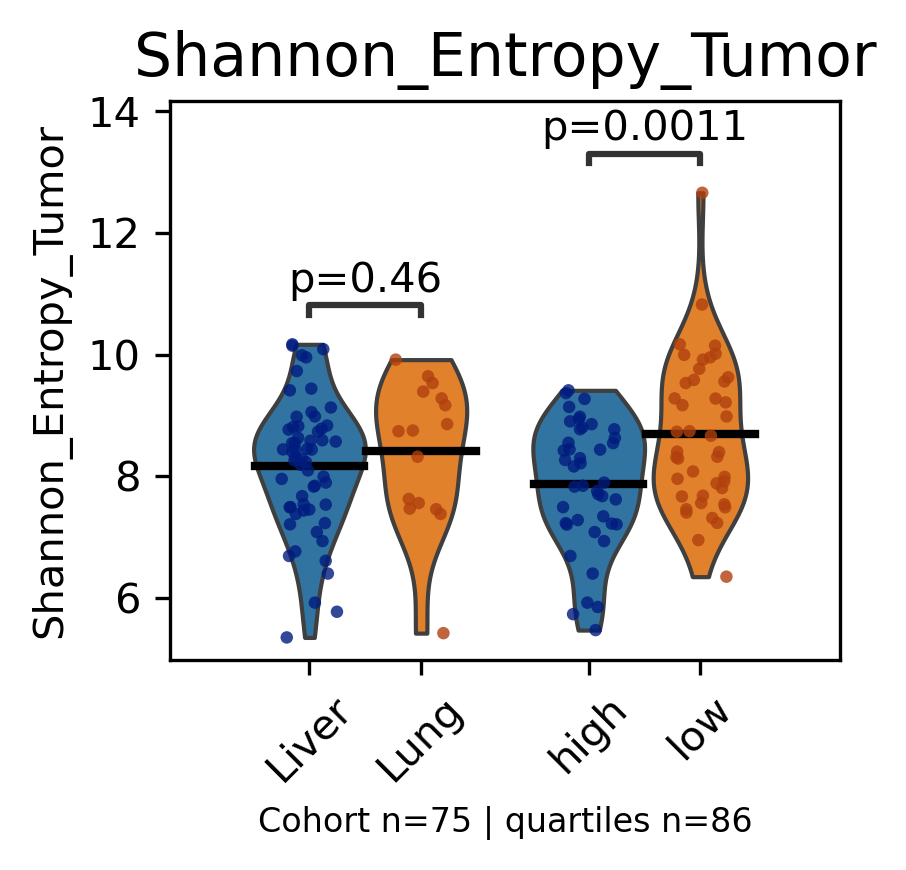

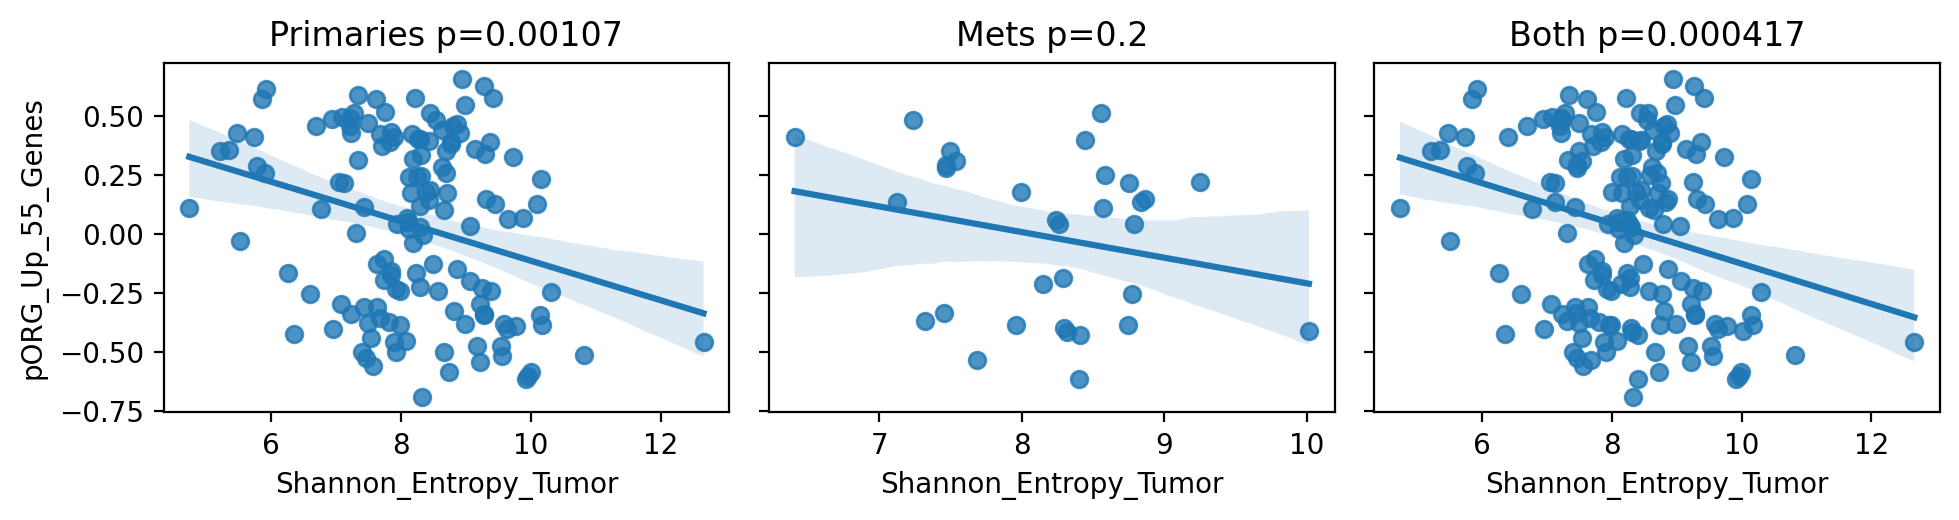

In [134]:
# the greater the absolute value of the slope, the greater the diversity.
%matplotlib inline
df_pri = df_merge.copy() #pr outlier .drop(70)
if s_porg_group=='GSVA_Primaries': 
    print('Primaries')
    df_pri = df_merge.loc[~(df_pri.Patient_Specimen_ID.str.contains('-M',na=True))].copy()
elif s_porg_group=='GSVA_All': 
    print('Primaries and Mets')
elif s_porg_group == 'GSVA_Met':
    df_pri = df_merge.loc[df_pri.Patient_Specimen_ID.str.contains('-M',na=False)].copy()

alpha = 1
ls_foci = [
    'Shannon_Entropy_Tumor', #try 1 tailed t-test
     'Shannon_Entropy_Blood',
            #'Normalized_Shannon_Entropy_Tumor',
     #'Normalized_Shannon_Entropy_Blood',
     'Clonality_Tumor','Clonality_Blood',
            'Simpsons_Diversity_Tumor','Simpsons_Diversity_Blood',
           'Templates_per_ng',
    'Productive_Rearrangements',
            "Simpson's Evenness tumor", 
     "Simpson's Evenness blood",
            #'Number Tumor Distinct Clones', 
     'Fraction Tumor Distinct Clones',
     'Prod. Freq. Tumor Distinct Clones',
      #'Number Tumor Distinct Clones (rare)',
     'Fraction Tumor Distinct Clones (rare)',
           'Percent Tumor Distinct Clones',
          ]

#log transform? it doesn't change the residuals
#non- parametric:
se_non_para = pd.Series(['Simpsons_Diversity_Blood',
    'Templates_per_ng','Productive_Rearrangements',
     "Simpson's Evenness tumor", "Simpson's Evenness blood",
   'Number Tumor Distinct Clones',])


d_order =  {
    'Cohort':['Liver','Lung'],
    #'PurIST Subtype':['basal-like','classical'],
    'quartiles':['high','low'],
    #'No_Recurrence':[False,True]
    #'Recurrence_Sites':['Liver','None']
    #'tertiles':['high','low'],
    #'medians':['high','low']
     }

for s_foci in ls_foci:
    print(s_foci)
    if se_non_para.isin([s_foci]).any():
        s_stats = 'non-parametric'
    else:
        s_stats = 'mean' 
    order = []
    ls_ticks = []
    d_pval = {}
    df_both = pd.DataFrame()
    for idx, s_cat in enumerate(d_order.keys()):
        #print(s_cat)
        ls_order = d_order[s_cat]
        s_bad = ls_order[0]
        s_good = ls_order[1]
        d_replace = {s_bad:'bad',s_good:'good'}
        a = df_pri.loc[df_pri.loc[:,s_cat]==ls_order[0],s_foci].dropna()
        b = df_pri.loc[df_pri.loc[:,s_cat]==ls_order[1],s_foci].dropna()
        ##statistic, pvalue = stats.ttest_ind(a,b,alternative=s_alt)
        if s_stats == 'mean':
            statistic, pvalue = f_oneway(b,a)
        elif s_stats == 'non-parametric':
            statistic, pvalue = stats.kruskal(b,a)
        df_pri['hue'] = df_pri.loc[:,s_cat].replace(d_replace)
        df_pri['x'] = s_cat
        df_both=pd.concat([df_both,df_pri.loc[df_pri.hue.isin(['bad','good']),['x','hue',s_foci]]])
        for s_test in ls_order:
            order.append((s_cat,d_replace[s_test]))
            ls_ticks.append(s_test)
        d_pval.update({s_cat:pvalue})
        #anova eval
        #qq_plot_hist(df_pri,s_cat,s_foci)
    #plotting func
    #''' switch bright and faint
    fig,pvalues,corrected = plot_violins(df_both,d_pval,d_order,s_stats,s_foci,order,ls_ticks,b_correct=False)#True#False
    fig.savefig(f'figures/violinplot_both_{s_foci}_{list(d_order.keys())[-1]}_{s_porg_group}_{s_stats}.png')
    if np.array(pvalues).min() > alpha:
        plt.close(fig)
    #'''
    #and pearson
    if not s_porg_group=='GSVA_All':
        #pass
        fig, ax = plt.subplots()
        pvalues = [5,5]
    elif s_porg.find('.')>-1:
        fig, pvalues = plot_pearson(df_pri,s_porg,s_foci,s_stats,ls_plots=['Primaries','Mets','Both'])
        fig.savefig(f'figures/scatterplot_pearson_{s_foci}_{list(d_order.keys())[-1]}_{s_porg_group}_{s_stats}.png')
    else:
        fig, pvalues = plot_pearson(df_pri,s_porg,s_foci,s_stats,ls_plots=['Primaries'])
    if np.array(pvalues).min() > alpha:
        plt.close(fig)
        #plot_pearson(df_pri,'Percent Tumor Distinct Clones',s_foci)
    #'''
    break
    

In [135]:
import matplotlib as mpl
df_merge['Survival interval'] = pd.qcut(df_merge.Survival_time,6)
ls_annot = ['Tumor Type', 'Cohort', 'medians','Survival interval']
cmap=plt.cm.get_cmap('Blues', 6)
ls_color=[mpl.cm.tab10.colors,mpl.cm.Set1.colors,mpl.cm.Set2.colors,
          #mpl.cm.Set3.colors,
          #mpl.cm.Paired.colors,mpl.cm.Pastel1.colors
         [cmap(item) for item in np.arange(0,1,.17)]]
df_annot = pd.DataFrame()
dd_color = {}
for idx, s_annot in enumerate(ls_annot):
    color_palette = ls_color[idx]
    d_color = dict(zip(sorted(df_merge.loc[:,s_annot].dropna().unique()),color_palette[0:len(df_merge.loc[:,s_annot].dropna().unique())]))
    d_color.update({'NA':'lightgray'})
    network_colors = df_merge.loc[:,s_annot].astype('object').fillna('NA').map(d_color)
    df_annot[s_annot] = pd.DataFrame(network_colors)
    dd_color.update({s_annot:d_color})

Text(0.5, 1.0, 'trim_padj_0.2_pORG_Up_55_Genes')

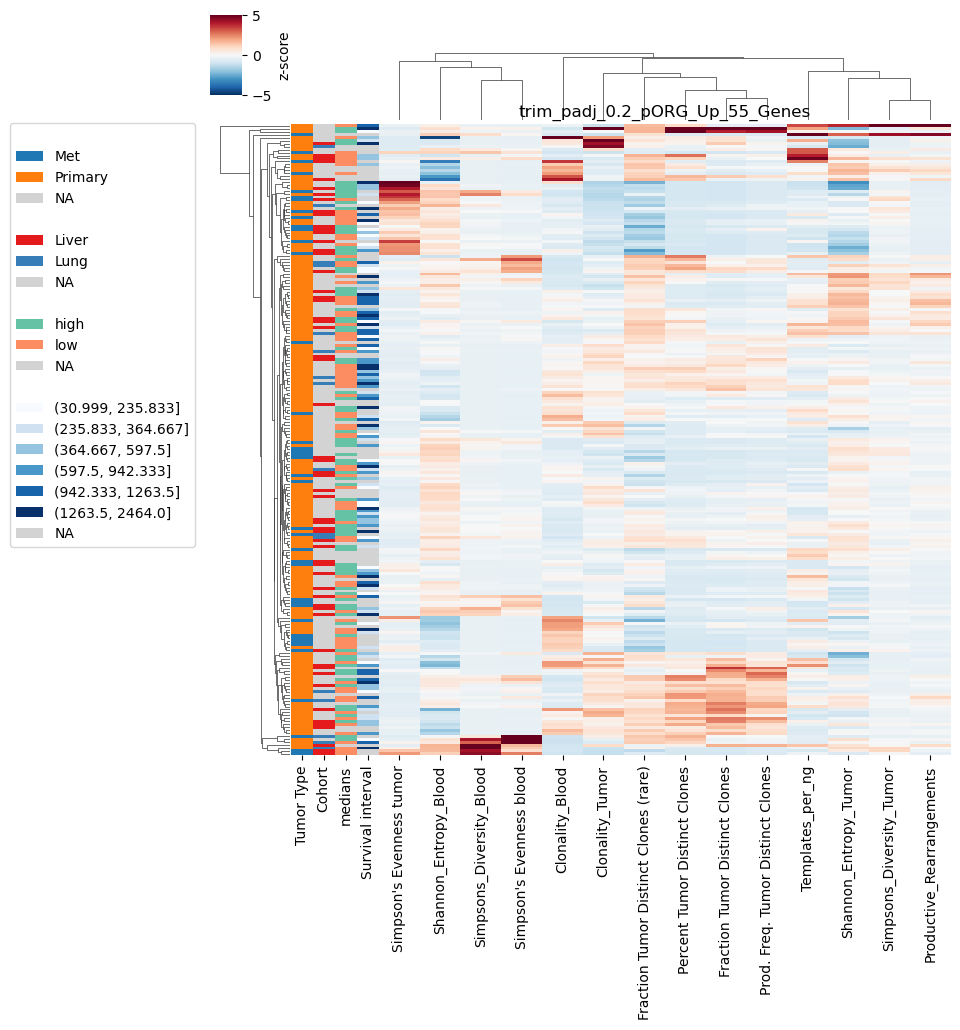

In [136]:
from matplotlib.pyplot import gcf
g = sns.clustermap(df_merge.loc[:,ls_foci].dropna(),z_score=1,dendrogram_ratio=0.1,cmap='RdBu_r',vmin=-5,vmax=5,
      cbar_pos=(0.01, 0.94, 0.04, 0.08),figsize=(8, 10),row_colors=df_annot,cbar_kws={'label': 'z-score'})
for idx, (s_annot, d_color) in enumerate(dd_color.items()):
    g.ax_col_dendrogram.bar(0, 0, color='w',label=' ', linewidth=0)
    for label,color in d_color.items():
        g.ax_col_dendrogram.bar(0, 0, color=color,label=label, linewidth=0)
g.ax_heatmap.set_yticks([])

l1 = g.ax_col_dendrogram.legend(loc="right", ncol=1,bbox_to_anchor=(0, 0.7),bbox_transform=gcf().transFigure)
g.ax_heatmap.set_title(s_porg)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Primary vs. Met: Mann-Whitney-Wilcoxon test two-sided, P_val:7.154e-01 U_stat=1.125e+02


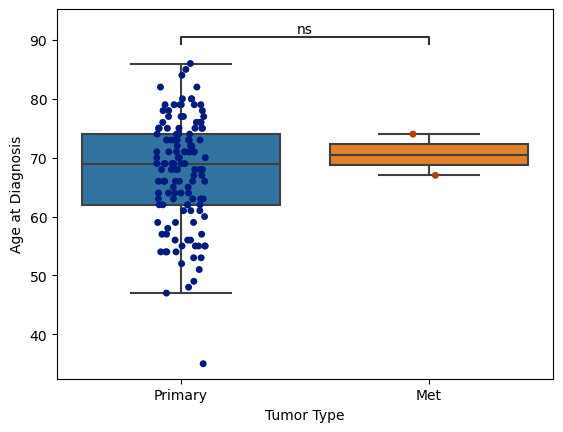

In [86]:
#df_pri.loc[:,['Public_Patient_ID','Tumor Type','quartiles']].to_csv('../pORG_high_low_quartiles.csv')
import itertools
for x in ['Tumor Type','quartiles','Cohort']:
    fig, ax = plt.subplots()
    sns.boxplot(data=df_pri,x=x,y='Age at Diagnosis',ax=ax,showfliers=False)
    sns.stripplot(data=df_pri,x=x,y='Age at Diagnosis',ax=ax,palette='dark')
    pairs = [item for item in itertools.combinations(df_pri.loc[:,x].dropna().unique(), 2)]
    annotator = Annotator(ax=ax, pairs=pairs,data=df_pri,x=x,y='Age at Diagnosis')
    annotator.configure(test='Mann-Whitney', verbose=2).apply_test().annotate()
    break

STAT1_low vs. STAT1_high: p=5.7e-08
CD4_low vs. CD4_high: p=0.43
CD3E_low vs. CD3E_high: p=0.023
CD8A_low vs. CD8A_high: p=0.00035
MS4A1_low vs. MS4A1_high: p=0.00035
CD68_low vs. CD68_high: p=0.021
OLR1_low vs. OLR1_high: p=3.5e-05
MRC1_low vs. MRC1_high: p=0.025
MX1_low vs. MX1_high: p=1e-06


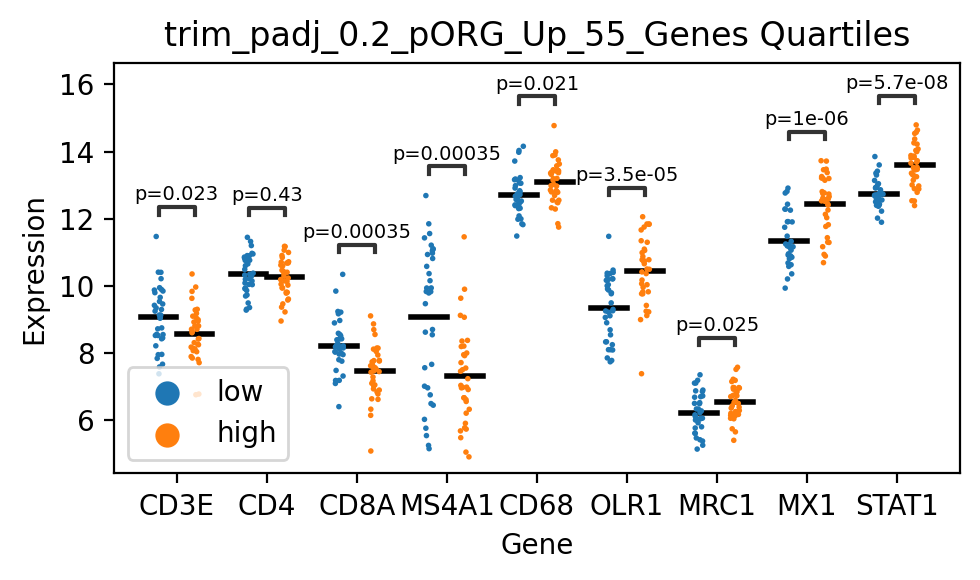

In [83]:
#high low
#liver vs lung (run t cell section to load t cell data!)
ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1','CD68','OLR1','MRC1','MX1','STAT1',]
df_plot = df_rna.loc[df_rna.Public_Patient_ID.isin(df_tcell.Public_Patient_ID),ls_marker].unstack().reset_index()
df_plot['Public_Patient_ID'] = [item[0:-2] for item in df_plot.level_1]
df_plot['pORG'] = df_plot.Public_Patient_ID.map(dict(zip(df_pri.Public_Patient_ID,df_pri.quartiles)))
df_plot.rename({0:'Expression','level_0':'Gene'},axis=1,inplace=True)
fig,ax = plt.subplots(dpi=200,figsize=(5,3))
sns.stripplot(data=df_plot,x='Gene',y='Expression',hue='pORG',dodge=True,ax=ax,s=2)
sns.boxplot(data=df_plot,x='Gene',y='Expression',hue='pORG',ax=ax,showmeans=True,medianprops={'visible': False},
                       whiskerprops={'visible': False},meanline=True,showcaps=False,
                       meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2],l[0:2],loc='lower left')
pairs = [((item,'low'),(item,'high')) for item in ls_marker]
annot = Annotator(ax, pairs, data=df_plot,x='Gene',y='Expression',hue='pORG',
                  order=ls_marker,hue_order=('low','high'))
annot.configure(test='t-test_ind', text_format='simple',fontsize=7,comparisons_correction='fdr_bh') #
annot.apply_test()#.annotate()
d_pval = dict([(res.data.group1[0],res.data.pvalue) for res in annot.annotations])
pvalues = [d_pval[item] for item in ls_marker]
reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
annot.set_custom_annotations(formatted_pvalues)
annot.annotate()

ax.set_title(f'{s_porg} Quartiles') #\n{s_porg_group}
plt.tight_layout()

## Met's survival
#can I add the mets' survival ? are those from the same or different patients

#df_merge.loc[~df_merge.loc[:,s_type].isna(),[s_cat,s_time,s_censor]].dropna()

In [ ]:
df_mets = pd.read_csv(f'../Mets_In_TCR.csv',index_col=0)
df_mets.rename({'Participant_ID':'OPTR'},axis=1,inplace=True)
df_mets.dtypes
df_id = pd.read_csv('Patient_IDs.csv',index_col=0).rename({'Biolibrary.Subject.ID':'Public_Patient_ID',
                                                          'Public.Specimen.ID':'Public_Specimen_ID'},axis=1)
b_met = df_id.Public_Specimen_ID.str.contains('-M')
b_pri = df_id.Public_Specimen_ID.str.contains('-T')
d_id_met = dict(zip(df_id.loc[b_met,'Public_Patient_ID'],df_id.loc[b_met,'OPTR.Specimen.ID']))
d_id_pri = dict(zip(df_id.loc[b_pri,'Public_Patient_ID'],df_id.loc[b_pri,'OPTR.Specimen.ID']))
#add optr
b_met2 = df_merge.loc[:,'Tumor Type'] == 'Met'
df_merge.loc[b_met2,'OPTR'] = df_merge[df_merge.loc[:,'Tumor Type'] == 'Met'].Public_Patient_ID.map(d_id_met)
df_merge.loc[df_merge.loc[:,'Tumor Type'] == 'Primary','OPTR'] = df_merge[df_merge.loc[:,'Tumor Type'] == 'Primary'].Public_Patient_ID.map(d_id_pri)
#df_merge['subtype'] = 'All'
se_met = df_merge.loc[df_merge.loc[:,'Tumor Type'] == 'Met','OPTR']
se_pri = df_merge.loc[df_merge.loc[:,'Tumor Type'] == 'Primary','OPTR']
df_merge.loc[df_merge.loc[:,'Tumor Type'] == 'Met','OPTR'] = [np.int64(item.split('-')[0]) for item in se_met]
print(len(se_pri)) #175 minus 1
print(len(se_met)) #43 minus 1
# #
# es_unique = set([np.int64(item.split('-')[0]) for item in se_met]) - set([np.int64(item.split('-')[0]) for item in se_pri])
# len(es_unique)


In [ ]:
b_met2 = df_merge.loc[:,'Tumor Type'] == 'Met'
df_merge = df_merge.merge(df_mets,on='OPTR',how='left',suffixes=('','_x'))#.loc[b_met2] #'Vital Status','Overall Survival (Days)'
df_merge.Survival = df_merge.Survival.fillna(df_merge.loc[:,'Vital Status'])
df_merge.Survival_time = df_merge.Survival_time.fillna(df_merge.loc[:,'Overall Survival (Days)'])

In [ ]:
#df_merge.loc[(df_merge.loc[:,'Tumor Type']=='Met'),['Cohort','medians']]

In [ ]:
ls_foci = [
    'Shannon_Entropy_Tumor', 
    'Shannon_Entropy_Blood',
           'Normalized_Shannon_Entropy_Tumor',
    'Normalized_Shannon_Entropy_Blood',
           'Simpsons_Diversity_Tumor','Simpsons_Diversity_Blood',
            'Templates_per_ng','Productive_Rearrangements',
           "Simpson's Evenness tumor", 
    "Simpson's Evenness blood",
           'Number Tumor Distinct Clones', 
    'Fraction Tumor Distinct Clones',
    'Prod. Freq. Tumor Distinct Clones',
     'Number Tumor Distinct Clones (rare)','Fraction Tumor Distinct Clones (rare)',
          'Percent Tumor Distinct Clones',
          ]

s_time = 'Survival_time'
s_censor = 'Survival'
alpha = 0.1
s_subtype = ''#'Primary'#'Met'
s_cell = ''
s_type_title = ''
savedir = '.'
s_propo= ''
if s_subtype == '':
    df_km_samples = df_merge[(df_merge.medians=='low') & (df_merge.loc[:,'Tumor Type']=='Primary')]#df_merge[df_merge.Cohort=='Lung']#
else:
    print(s_subtype)
    df_km_samples = df_merge[df_merge.loc[:,'Tumor Type'] == s_subtype]
for s_col in ls_foci:
    print(s_col)
    #s_col ='Templates_per_ng'
    for cutp in [0.5,0.33,0.66]: #
            print(cutp)
            df_km, pvalue = util.single_km(df_km_samples,s_cell,s_subtype,s_type_title,s_col,savedir,alpha,cutp, #
                                       s_time,s_censor,s_propo)
            print(pvalue)
            #break
    #break

In [ ]:
# def statistic(x):  # permute only `x`
#     return stats.spearmanr(x, y).statistic


# for s_even in ["Simpson's Evenness tumor","Simpson's Evenness blood"]:
#     y = df_merge.loc[:,'Tumor Distinct Clones 100-x'].dropna()
#     x = df_merge.loc[y.index,s_even]
#     statistic, pvalue = stats.pearsonr(x, y)
#     print(f'{s_even}: r={statistic:.3} p={pvalue:.3} (Pearson)')
#     statistic, pvalue = stats.spearmanr(x, y)
#     print(f'{s_even}: r={statistic:.3} p={pvalue:.3} (Spearman)')
#     statistic, pvalue = stats.kendalltau(x, y)
#     print(f'{s_even}: r={statistic:.3} p={pvalue:.3} (Kendall Tau)')
# #     res_exact = stats.permutation_test((x,), statistic,
# #                                    permutation_type='pairings')
# #     print(res_asymptotic.pvalue)


In [ ]:
s_time = 'Survival_time'
s_censor = 'Survival'
s_porg = 'trim_padj_0.2_pORG_Up_55_Genes'

for s_type in ["Simpson's Evenness tumor","Simpson's Evenness blood"]:
    s_bld = s_type.split(' ')[-1]
    for idx, s_cat in enumerate(d_order.keys()):
        df = df_merge.loc[~df_merge.loc[:,s_type].isna(),[s_cat,s_time,s_censor,s_porg]].dropna(how='any')
        s_rename = f'{s_cat} TCR {s_bld}'
        df.rename({s_cat:s_rename},axis=1,inplace=True)
        fig, __ = km_plot(df,s_rename,s_time,s_censor)
        fig.savefig(f'figures/KM_clinicopath_{s_foci}_{s_cat}.png')
        #PLOT pORG
        ls_order = df.loc[:,s_rename].unique()
        #define samples
        group1 = df[df[s_rename]==ls_order[0]]
        group2 = df[df[s_rename]==ls_order[1]]
        #perform independent two sample t-test
        statistic, pvalue = stats.ttest_ind(group1[s_porg], group2[s_porg])
        fig,ax=plt.subplots(figsize=(3,3),dpi=200)
        sns.boxplot(data=df,x=s_rename,y=s_porg,showfliers=False)
        sns.stripplot(data=df,x=s_rename,y=s_porg,palette='dark')
        ax.set_title(f'{s_rename} p={pvalue:.03}')
        #break
    #break


In [ ]:
df_both.dropna().groupby(['x','hue']).count()
#35, 35 low pORG primary!!
#16 lung, 59 liver 
# 45 basal like

## Section 7 <a name="split"></a>


evaluate high/low

[contents](#contents)

In [51]:
#load data
#specify
s_primary = 'Primaries'#'GSVA_All'#'GSVA_Primary'#'GSVA_Met'#
df_patient = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1_age.xlsx',
                           sheet_name='Patients - Tab 1')
df_patient.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
df_patient.loc[df_patient.loc[:,'Lung Met Present']=='YES','Cohort'] = 'Lung'
df_patient.loc[df_patient.loc[:,'Liver Met Present']=='YES','Cohort'] = 'Liver'#primaries

#df_pORG = pd.read_csv(f'{codedir}/20230526_GSVA_Scores.csv')
df_pORG = pd.read_csv(f'../20230608_GSVA_Scores.csv')
df_pORG = pd.read_csv(f'../annotation/GSVA_{s_primary}_pORG_0.14_0.15.tsv',sep='\t')
#df_pORG = pd.read_csv(f'../annotation/GSVA_Primaries_Kallisto55_pSUB1e-4and1e-5.tsv',sep='\t')
df_pORG['Patient Specimen ID'] = df_pORG.SampleID.map(dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Public.Specimen.ID'])))

#old
#df_pORG['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_pORG.Public_Specimen_ID]
#df_patient = df_patient.merge(df_pORG[df_pORG.Group==s_primary],on='Public_Patient_ID',suffixes=('',"_x"))
df_pORG['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_pORG.loc[:,'Patient Specimen ID']]
df_patient = df_patient.merge(df_pORG,on='Public_Patient_ID',suffixes=('',"_x"))

df_vital = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/FMP_Patients_Nov17_2021.xlsx',sheet_name='Sheet1')
df_vital['Survival'] = df_vital.cVitalStatus.replace({'Alive':0,'Dead':1})


In [52]:
#load ids
d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}annotation/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

df_id = d_ids['RnaSeqKey']
ls_ids = df_id.loc[:,'Public.Specimen.ID']

# add patients w/o RNA seq
for s_key in ['TcrTumorKey','TcrBloodKey']:
    df_add = d_ids[s_key].loc[~d_ids[s_key].loc[:,'Public.Specimen.ID'].isin(ls_ids)]
    df_id = pd.concat([df_id,df_add])

#check
print(df_id.loc[:,'OPTR.Specimen.ID'].duplicated().any())

ls_drop = df_id.loc[df_id.loc[:,'OPTR.Specimen.ID'].str.contains('-T2')].index
df_unique = df_id.loc[df_id.loc[:,'OPTR.Specimen.ID'].str.contains('-T')].drop(ls_drop)

#check
print(df_unique.OPTR.duplicated().any())

#add id
df_vital['Public_Patient_ID'] = df_vital.OPTR.map(dict(zip(df_unique.OPTR,df_unique.loc[:,'Biolibrary.Subject.ID'])))

#omics data plus clinical data
df_patient = df_patient.merge(df_vital,on='Public_Patient_ID',how='left')



False
False


In [53]:
# load purIST
s_primary_select = 'Primary'#'Met'#''#
df_gsva = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx', sheet_name='Specimen Subtype - Tab 2')
df_gsva.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
if s_primary == 'GSVA_Primary':#'GSVA_Met'#
    df_gsva_pri = df_gsva[~df_gsva.loc[:,'Patient Specimen ID'].str.contains('-M')]
elif s_primary == 'GSVA_Met':#'GSVA_Met'#
    df_gsva_pri = df_gsva[df_gsva.loc[:,'Patient Specimen ID'].str.contains('-M')]
elif s_primary_select == 'Primary':#'GSVA_Met'#
    df_gsva_pri = df_gsva[~df_gsva.loc[:,'Patient Specimen ID'].str.contains('-M')] #primaries
elif s_primary_select == 'Met':#'GSVA_Met'#
    df_gsva_pri = df_gsva[df_gsva.loc[:,'Patient Specimen ID'].str.contains('-M')] #mets
    
ls_patients = df_gsva_pri.Public_Patient_ID

    
for s_cat in ['PurIST Subtype']:
    df_patient[s_cat] = df_patient.Public_Patient_ID.map(dict(zip(df_gsva_pri.Public_Patient_ID,df_gsva_pri.loc[:,s_cat])))
    
df_pri = df_patient[df_patient.Public_Patient_ID.isin(ls_patients)]

## figure 2


Cohort
76
PurIST Subtype
218
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PurIST Subtype_bad vs. PurIST Subtype_good: p=0.46
Cohort_bad vs. Cohort_good: p=1.8e-08
Cohort
76
PurIST Subtype
218
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PurIST Subtype_bad vs. PurIST Subtype_good: p=0.48
Cohort_bad vs. Cohort_good: p=3.5e-08


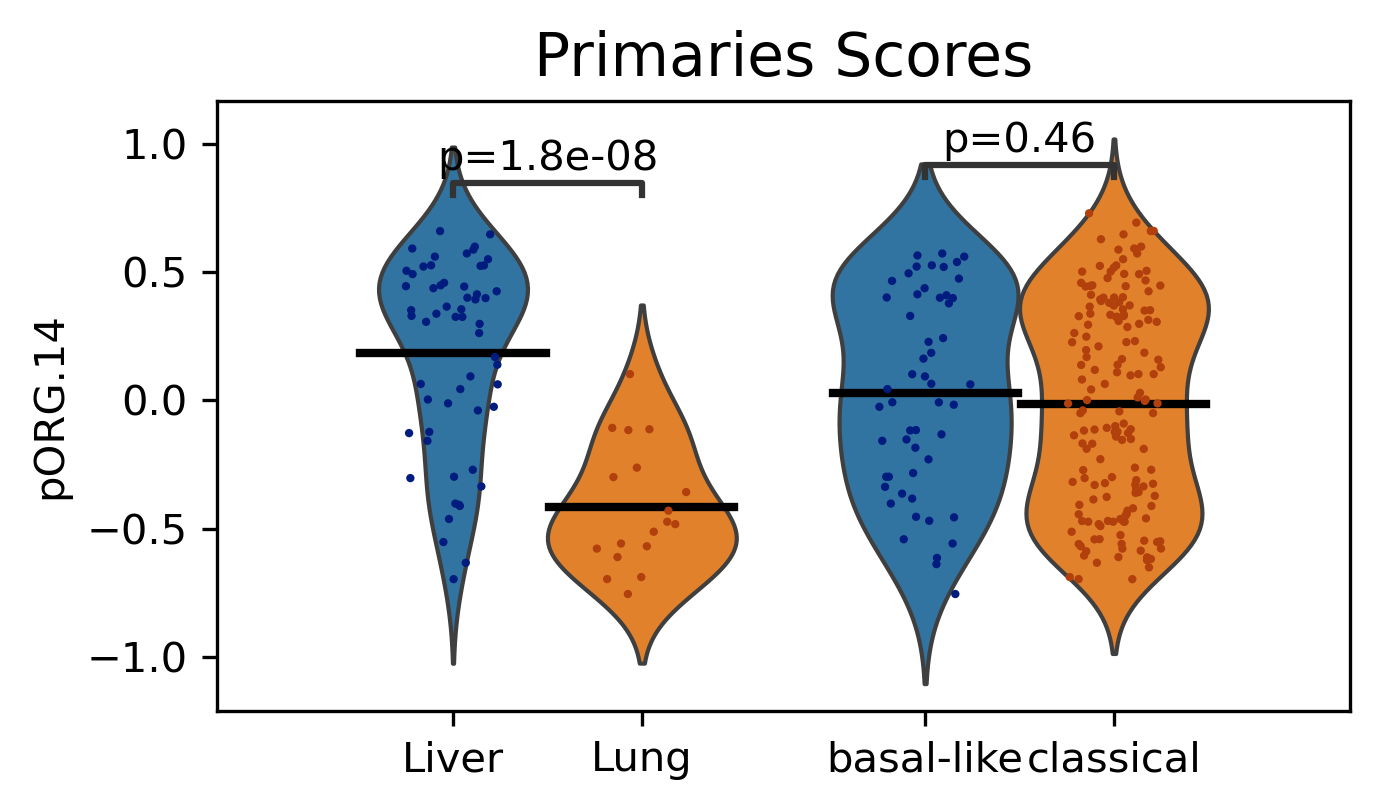

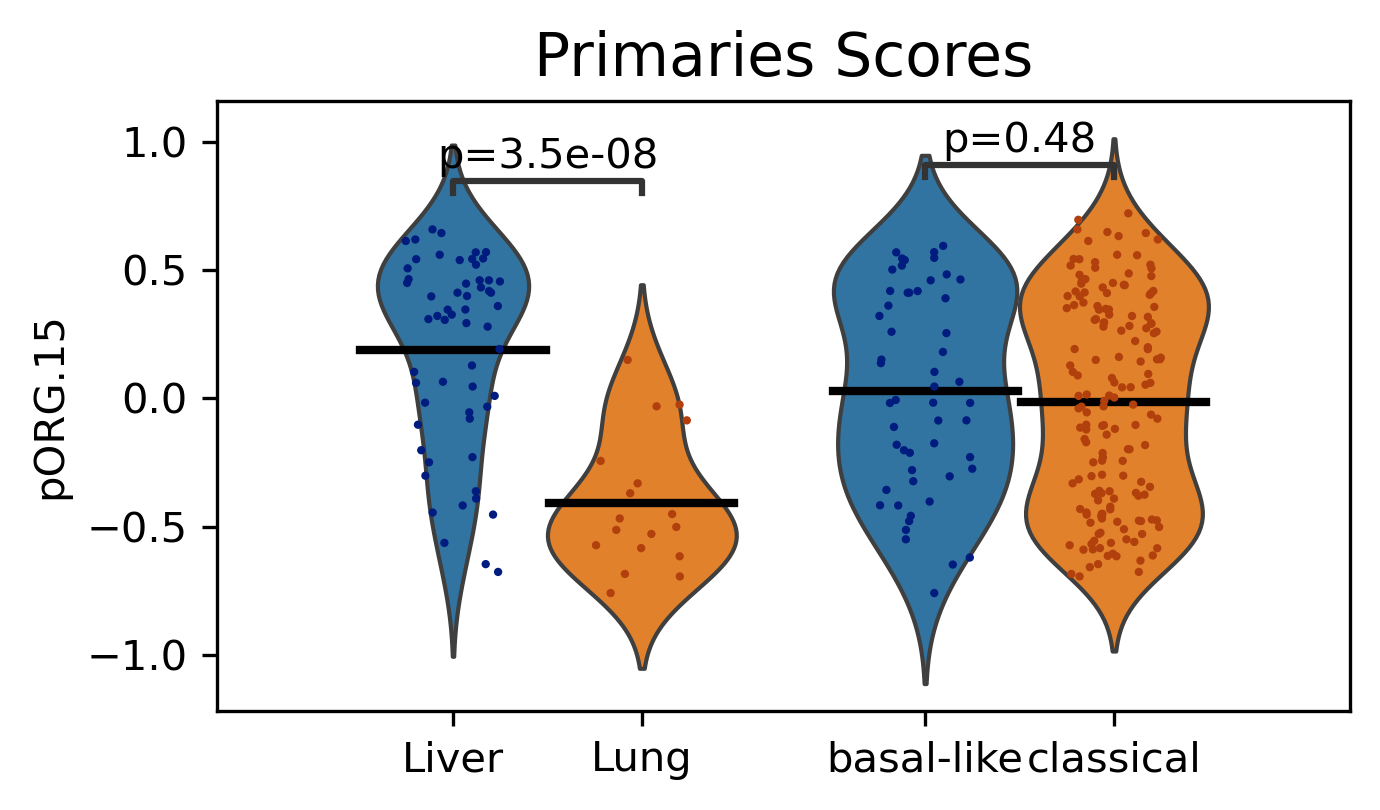

In [54]:
#need to get mets 

ls_foci = [#'Original_pORG_Up_78_Genes', 
           #'txi_pORG_Up_42_Genes',
#     'trim_padj_0.2_pORG_Up_55_Genes',
#     'trim_padj_0.2_pSUB_Up_100_Genes',
       #'Original_pSUB_Up_100_Genes', 
        #'txi_pSUB_Up_100_Genes'
    'pORG.14', 'pORG.15',
   ]
d_order =  {'Cohort':['Liver','Lung'],
            'PurIST Subtype':['basal-like','classical']}
for s_foci in ls_foci:
    figsize=(4.7,2.8)
    fig,ax=plt.subplots(dpi=300,figsize=figsize)
    order = []
    ls_ticks = []
    d_pval = {}
    df_both = pd.DataFrame()
    for idx, s_cat in enumerate(d_order.keys()):
        print(s_cat)
        ls_order = d_order[s_cat]
        s_bad = ls_order[0]
        s_good = ls_order[1]
        d_replace = {s_bad:'bad',s_good:'good'}
        a = df_pri.loc[df_pri.loc[:,s_cat]==ls_order[0],s_foci]
        b =df_pri.loc[df_pri.loc[:,s_cat]==ls_order[1],s_foci]
        statistic, pvalue = stats.ttest_ind(a,b, )#    alternative='greater' )
        print(len(a) + len(b))
        df_pri['hue'] = df_pri.loc[:,s_cat].replace(d_replace)
        df_pri['x'] = s_cat
        df_both=pd.concat([df_both,df_pri.loc[:,['x','hue',s_foci]]])
        for s_test in ls_order:
            order.append((s_cat,d_replace[s_test]))
            ls_ticks.append(s_test)
        d_pval.update({s_cat:pvalue})
    sns.violinplot(data=df_both,y=s_foci,x='x',hue='hue',ax=ax,alpha=0.5,linewidth=1,inner=None)
    sns.boxplot(data=df_both,y=s_foci,x='x',hue='hue',ax=ax,showmeans=True,medianprops={'visible': False},
                       whiskerprops={'visible': False},meanline=True,showcaps=False,
                       meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
    sns.stripplot(data=df_both,y=s_foci,x='x',hue='hue',s=2,dodge=True,ax=ax,palette='dark',jitter=0.2) #hue='Ki67pos'
    #annotate
    pairs = [(order[0],order[1]),(order[2],order[3])]
    pvalues = [d_pval[list(d_order.keys())[0]],d_pval[list(d_order.keys())[1]]]
    reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
    formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
    annotator = Annotator(ax, pairs=pairs, data=df_both,y=s_foci,x='x',hue='hue')
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
    ax.legend().remove()
    ax.set_xticks([-0.2,0.2, 0.8,1.2])
    ax.set_xticklabels(ls_ticks)
    ax.set_xlabel('')
    ax.set_title(f"{s_primary} Scores", fontsize='x-large') #{s_foci.replace('_',' ')} vs. 
    plt.tight_layout()
    fig.savefig(f'figures/violinplot_both_{s_foci}_primary.png')
    #break

In [ ]:
# different splits
d_col = {#'quartiles':(4,['low','med-low','med-high','high']), #
         'median':(2,['low','high']),
         #'tertiles':(3,['low','med','high']),
         #'#tertiles_h':([0, .33, 1.],['low','high']),
         #'tertiles_l':([0, .66, 1.],['low','high'])
        }

for s_col, tu_cut in d_col.items():
    i_cut = tu_cut[0]
    labels = tu_cut[1]
    break

for s_vital in ls_foci:
    #s_vital = s_vital_[0]
    print(s_vital)
    df = df_pri.copy()
    x = df.loc[:,s_vital]
    q = pd.qcut(x, q=i_cut,labels=labels) 
    if s_col == 'quartiles':
        df[s_vital] = q.replace({'med-low':np.NaN,'med-high':np.NaN})
    elif s_col == 'tertiles':
        df[s_vital] = q.replace({'med':np.NaN})
    else:
        df[s_vital] = q 
    df = df.loc[:,[s_vital,s_time,s_censor]].dropna(how='any')
    fig, __ = km_plot(df,s_vital,s_time,s_censor)
    fig.savefig(f'figures/KM_{s_col}_{s_vital}.png')
    #break